<a href="https://colab.research.google.com/github/hduongck/AI-ML-Learning/blob/master/Machine_Learning_Lesson_3_2%264%265_RandomForest_interpretion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Import Library and getting Data

%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install fastai==0.7.0
!pip install torchtext==0.2.3

!pip install kaggle
!mkdir .kaggle

import os
import json 
token = {"username":"hduongck","key":"983e2ab1fbb29cf2734bcbf8811d42fb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

os.makedirs('/data/bulldozers/', exist_ok=True)
os.makedirs('/.kaggle/',exist_ok=True) 
!chmod 600 /content/.kaggle/kaggle.json

!kaggle config set -n path -v{/content/data}



!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c bluebook-for-bulldozers -p /content/data/bulldozers


!unzip /content/data/bulldozers/\Train.zip -d data/bulldozers

#!mkdir data/rossmann
#!wget http://files.fast.ai/part2/lesson14/rossmann.tgz
#!tar -xvzf /content/rossmann.tgz -C /content/data/rossmann

In [0]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [0]:
set_plot_sizes(12,14,16)

In [0]:
PATH ='data/bulldozers/'
!ls {PATH}

Data%20Dictionary.xlsx		  Train.7z	     Valid.7z
Machine_Appendix.csv		  TrainAndValid.7z   Valid.csv
median_benchmark.csv		  TrainAndValid.csv  ValidSolution.csv
random_forest_benchmark_test.csv  TrainAndValid.zip  Valid.zip
Test.csv			  Train.csv
tmp				  Train.zip


In [0]:
df_raw = pd.read_csv(f'{PATH}Train.csv',parse_dates=['saledate'],low_memory=False)
df_raw.SalePrice = np.log(df_raw.SalePrice)
add_datepart(df_raw,'saledate')
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High','Medium','Low'],ordered=True,inplace=True)


#Interpreting Random Forest [50:38](https://youtu.be/YSFG_W8JxBo?t=50m38s) 

In [0]:
df_trn, y_trn, nas = proc_df(df_raw,'SalePrice')

We start by reading in our feature files for Blue Books for Bulldozers competition. Reminder: we have already read in the CSV, processed it into categories, and save it in feather format. The next thing we do is call proc_df to turn categories into integers, deal with missing values, and pull out the dependent variable. Then create a validation set just last week:

In [0]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn,n_trn)
y_train, y_valid = split_vals(y_trn,n_trn)
raw_train, raw_valid = split_vals(df_raw,n_trn)


In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train),y_train),
          rmse(m.predict(X_valid),y_valid),
          m.score(X_train,y_train),
          m.score(X_valid,y_valid)]
    if hasattr(m,'oob_score_') : res.append(m.oob_score_)
    print (res)
    

**Detour to lesson 1 notebook** [51:59](https://youtu.be/YSFG_W8JxBo?t=51m59s)

Last week, there was a bug in **proc_df** that was shuffling the dataframe when subset gets passed in hence causing the validation set to be not the latest 12000 records. The issue was fixed by using **nas**. 


```
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice',subset=30000,na_dict=nas)
X_train, _ = split_vals (df_trn,20000)
y_train,_ = split_vals(y_trn,20000)

```

Question : Why is nas both input and output of this function [53:03](https://youtu.be/YSFG_W8JxBo?t=53m3s)? **proc_df** returns a dictionary telling you which columns were missing and for each of those columns what the median was.

1. When you call **proc_df** on a larger dataset, you do not pass in **nas** but you want to keep that return value.
2. Later on, when you create a **subset**(by passing in subset), you want to use the same missing columns and medians, so you pass **nas** in.
3. If it turns out that the subset was from a whole different dataset and had different missing columns, it would update the dictionary with additional key value. 
4. It keeps track of any missing columns you came across in anything you passed to **proc_df**





**Back to lesson 2 notebook** [54:40](https://youtu.be/YSFG_W8JxBo?t=54m40s)

Once we have done **proc_df**, this what it looks like. SalePrice is the log of the sale price. 

![alt text](https://cdn-images-1.medium.com/max/750/1*OAFGr5BtbwZzZBxMa_z0AQ.png)

We already know how to get the prediciton. We take the average value in each leaf node in each tree after running a particular row through each tree. Normally, we do not just want a prediction -- we also want to know how confident we are of that prediction.

We would be less confident of a prediction if we have not seen many examples of rows like this one. In that case, we would not expect any of the trees to have a path through -- which is designed to help us predict that row. So conceptually, you would expect then that as you pass this unusual row through different trees, it is going to end up in very different places. In other words, rather than just taking the mean of the predictions of the trees and saying that is our prediction, what if we took the standard deviation of the prediction of the trees? If the standard deviation is high, that means each tree is giving us a very different estimate of this row's prediction. If this was a really common kind of row, the trees would have learned to make good predictions for it because it has seen lots of opportunities to split based on those kind of rows. **So standard deviation of the predictions across the trees gives us least relative understanding of how confident we are of this prediction** [56:39](https://youtu.be/YSFG_W8JxBo?t=56m39s). This is not something which exists in scikit-learn , so we have to create it. But we already have almost the exact code we need.

For model interpretation, there is no need to use the full dataset because we do not need a massively accurate random forest -- we just need one which indicates the nature of relationships involved. 

Just make sure the sample size is large enough that if you call the same interpretation commands multiple times, you do not get different results back each time. In practice, 50,000 is a high number and it would be surprising if that was not enough ( and it runs in seconds)

In [0]:
set_rf_samples(50000)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf = 3, max_features = 0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20565014869077836, 0.2513510618815602, 0.9116120865405059, 0.8871739399371599, 0.8946213471610777]


Here is where we can do the exact same list comprehension as the last time [58:35](https://youtu.be/YSFG_W8JxBo?t=58m35s)

In [0]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.52 s, sys: 60.1 ms, total: 1.58 s
Wall time: 1.58 s


(9.246822846369724, 0.26096715035181667)

This is how to do it for one observation. This takes quite a while and specifically, it is not taking advantage of the fact that my computer has lots of cores in it. List comprehensions itself if Python code and Python code(unless you are doing somthing special) runs in serial which means it runs on a single CPU and does not take advantage of your multi CPU hardware. If we wanted to run this on more trees and more data, the execution time goes up. Wall time (the amount of actual time it took) is roughly equal to the CPU time where else if it was running on lots of core, the CPU time would be higher than the wall time [1:00:05](https://youtu.be/YSFG_W8JxBo?t=1h5s). 

It turns out Fast.ai library provides a handy function called **parallel_trees**:



In [0]:
def get_preds(t) : return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m,get_preds))
np.mean(preds[:,0]) , np.std(preds[:,0])

CPU times: user 109 ms, sys: 138 ms, total: 247 ms
Wall time: 1.64 s


(9.246822846369724, 0.26096715035181667)

the code lines 12 have same function as 11 , but thank to function parallel_trees to take advantage of multi cores

- parallel_trees takes a random forest model m and some function to call (here, it is get_preds). This calls this function on every tree in parallel.
- It will return a list of the result of applying that function to every tree. 
- This will cut down the wall time to 1.41s and giving exactly the same answer. Time permitting, we will talk about more general ways of writing code that runs in parallel which is super useful for data science, but here is on that we can use for random forests.

**Plotting** [1:02:02](https://youtu.be/YSFG_W8JxBo?t=1h2m2s)

We will first create a copy of the data and add the standard deviation of the predictions and predictions themself (the mean) as new column:

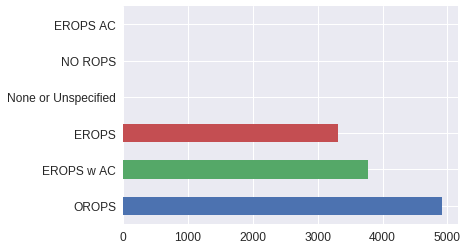

In [0]:
x = raw_valid.copy()
x ['pred_std'] = np.std(preds,axis=0)
x ['pred'] = np.mean(preds,axis = 0)
x.Enclosure.value_counts().plot.barh();

**Question** : Can you remind me what enclosure is [01:02:50](https://youtu.be/YSFG_W8JxBo?t=1h2m50s)

We do not know what it means and it does not matter. The whole purpose of this process is that we are going to learn about what things are (or at least what things are important and later on figure out what they are and how they are important). So we will start out knowing nothing about this dataset. We are just going to look at something called **Enclosure** that has something called **EROPS** and **ROPS** and we do not even know what this is yet. All we know is that the only three that appear in any great quantiy are **OROPS, EOPS w AC, and EROPS**. This is very common as a data scientist. You often find yourself looking at data that you are not that familiar with and you have to figure out which bits to study more carefully, which bits seem to matter, and so forth. In this case, at least know that **EROPS AC, NO ROPS, and None or Unspecified** we really do not care about because we basically do not exist. So we will focus on **OROPS, EROPS w AC and EROPS.**

Here we took our dataframe, grouped by Enclosure, then took average of 3 fields [1:04:00](https://youtu.be/YSFG_W8JxBo?t=1h4m):

In [0]:
flds = ['Enclosure','SalePrice','pred','pred_std']
enc_summ = x[flds].groupby('Enclosure',as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.834704,0.273909
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.570051,0.271392
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682048,0.224814


We can already start to learn a little here:
- Prediction and the sale price are close to each other on average (good sign)
- Standard deviation varies a little bit

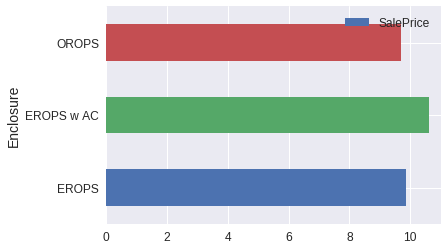

In [0]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure','SalePrice','barh',xlim=(0,11));

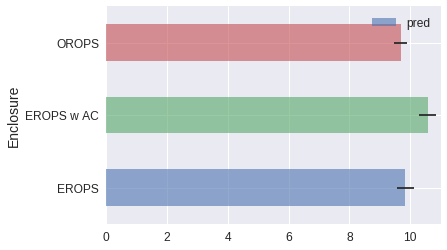

In [0]:
enc_summ.plot('Enclosure','pred','barh',xerr='pred_std',
             alpha = 0.6,xlim=(0,11))

We use the standard deviation of prediction for the error bars above. This will tell us if there is some groups or some rows that we are not very confident of at all. We could do something similar for product size:

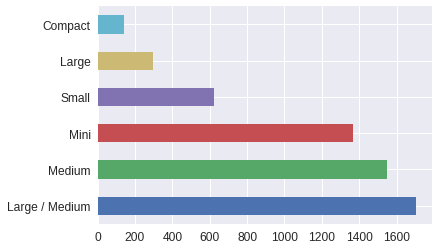

In [0]:
raw_valid.ProductSize.value_counts().plot.barh();

In [0]:
flds = ['ProductSize','SalePrice','pred','pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.868782,0.324892
Large,10.470589,10.385828,0.358330
Large / Medium,10.691871,10.635569,0.305050
Medium,10.681511,10.608765,0.293924
Mini,9.535147,9.558236,0.246491
Small,10.324448,10.322331,0.311588


You expect, on average, when you are predicting something that is a bigger number your standard deviation would be higher. So you can sort by the ratio of the standard deviation of the predictions to the predictions themself.[1:05:51](https://youtu.be/YSFG_W8JxBo?t=1h5m51s).

In [0]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.034502
Compact           0.032921
Small             0.030186
Large / Medium    0.028682
Medium            0.027706
Mini              0.025788
dtype: float64

What this tells us is that product size Large and Compact, our predictions are less accurate (relatively speaking as a ratio of the total price). So if we go back and have a look, you see why. These are the smallest groups in the histogram. As you would expect, in small groups, we are doing a less good job.

You can use this confidence interval for two main purposes:

1. You can look at the average confidence interval by group to find out if these are groups you do not seem to have confidence about.
2. Perhaps more importantly, you can look at them for specific rows. When you put it in production, you might always want to see the confidence interval. For example, if you are doing credit scoring to decide whether to give somebody a loan, you probably want to see not only what their level of risk is but how confident we are. If they want to borrow lots of money and we are not at all confident about our ability to predict whether they will pay pack, we might want to give them a smaller loan.

# Feature importance [1:07:20](https://youtu.be/YSFG_W8JxBo?t=1h7m20s)



```
I always look at feature importance first in practice. Whether I'am  working on a kaggle competition or a real world project, I build a random forest as fast as I can, trying to get it to the point that is significantly better than random but doesn't have to be much better than that. And the next thing I do is to plot the feature importance.
```
The feature importance tells us in this random forest, which columns mattered. We have dozens of columns in this dataset, and here, we are picking out the top 10. **rf_feat_importance** is part of Fasi.ai library which takes a model **m** and dataframe **df_trn** ( because we need to know names of columns) and it will give you back a Pandas dataframe showing you in order of importance how important each column was.



In [0]:
fi = rf_feat_importance(m,df_trn) ; fi[:10]

,cols,imp
5,YearMade,0.171517
37,Coupler_System,0.106734
13,ProductSize,0.097098
14,fiProductClassDesc,0.074394
2,ModelID,0.053025
10,fiSecondaryDesc,0.051256
63,saleElapsed,0.050240
38,Grouser_Tracks,0.046863
19,Enclosure,0.044980
39,Hydraulics_Flow,0.037468


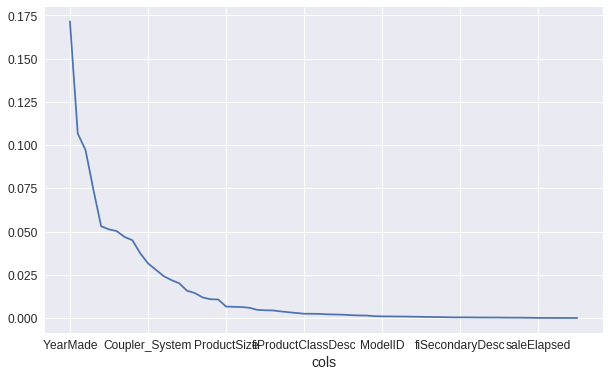

In [0]:
fi.plot('cols','imp',figsize=(10,6),legend=False);
plt.xticks(np.arange(len(fi),step=10),fi.cols.values);

Since fi is a DataFrame, we can use DataFrame plotting commands [1:09:00]. The important thing is to see that some columns are really important and most columns do not really matter at all. In nearly every dataset you use in real life, this is what your feature importance is going to look like. There is only a handful of columns that you care about, and this is why Jeremy always starts here. At this point, in terms of looking into learning about this domain of heavy industrial equipment auctions, we only have to care about learning about the columns which matter. Are we going to bother learning about **Enclosure**? Depends whether **Enclosure** is important. It turns out that i appears in top 10, so we are going to have to learn about **Enclosure.**

We can also plot this a bar plot:

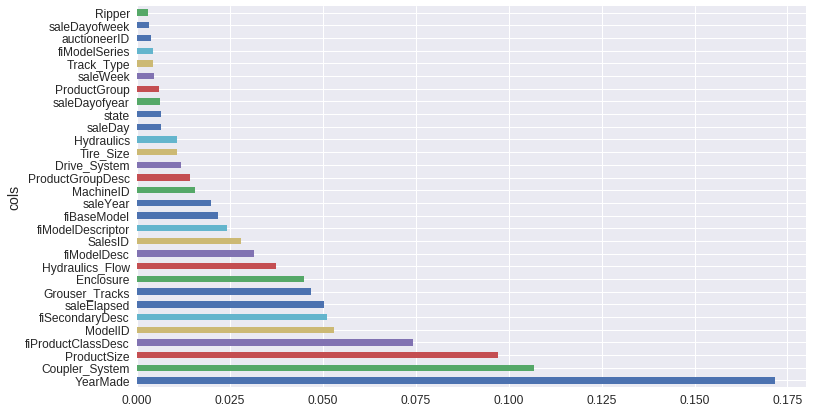

In [0]:
def plot_fi(fi):
    return fi.plot('cols','imp','barh',figsize=(12,7),legend=False)
plot_fi(fi[:30]);

The most important thing to do with this is to now sit down with your client, your data dictionary, or whether your source of information is and say to then "okay, tell me about **YearMade**. What does that mean? Where does it come from ? " [1:10:31](https://youtu.be/YSFG_W8JxBo?t=1h10m31s) Plot lots of things like histogram of **YearMade** and scatter plot of **YearMade** against price and learn everything you can because YearMade and Coupler_System - they are the things that matter.

What will often happen in real-world projects is that you sit with the client and you'll say "it turns out the coupler_System is the second most important thing" and they might say" that makes no sense". That doesn't mean that there is a problem with your model, it means there is a problem with their undstanding of the data they gave you. 

Let me give you an example [1:11:16](https://youtu.be/YSFG_W8JxBo?t=1h11m16s). I entered Kaggle competition where the goal was to predict which applications for grants at a university would be successful. I used this exact approach and I discovered a number of columns which were almost entirely predictive of the dependent variable. Specifically, when I then looked to see in what way they are predictive, it turned out whether they were missing or not was the only thing that mattered in his dataset. I ended up winning that competition thanks to this insight. Later on, I heard what had happened. It turns out that at that university, there is an administrative burden to fill any other database and so for a lot of the grant applications , they do not fill in the database and so for a lot of grant applications were not accepted. In other words, these missing values in the dataset were saying this grant was'nt accepted because if it was accepted then the admin folks will go in and type in that information. **This is what we call data leakage. Data leakage means there is information in the dataset what I was modeling with which the university would not have had in real life at that point in time they were making a decision**. When they actually deciding which grant applications to prioritize, they do not know which ones the admin staff will later on going to add information to because it turns out that they were accepted.

One of the key things, you will find here is data leakage problems and that is a serious problem you need to deal with [1:12:56]. The other thing that will happens is you will often find its **signs of collinearity**. It seems like what happend with Coupler_System. Coupler_System tells you whether or not a particular kind of heavy industry equipment has a particular feature on it. But if it is not that kind of industrial equipment at all, it will be missing. So it indicates whether or not it is a certain class of heavy industrial equipment. This is not data leakage. This is an actual information you actually have at the right time. You just have to be careful interpreting it. So you should go through at least the top 10 or look for where the natural break points are really study these things carefully.

To make life easier, it is sometimes good to throw some data away and see if it make any difference. In this case, we have random forest which was 0.889 $R^2$. Here we filter out those where the importance is equal to or less than 0.005. (i.e only keep the one whose importance is greater than 0.005).

In [0]:
to_keep = fi[fi.imp>0.0050].cols; len(to_keep)



24

In [0]:
df_keep = df_trn[to_keep].copy()
X_train,X_valid = split_vals(df_keep,n_trn)

In [0]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3, max_features=0.5,
                n_jobs=-1,oob_score=True)

m.fit(X_train,y_train)
print_score(m)

[0.20655256790740595, 0.24357632109550267, 0.9108346695810629, 0.8940458169005043, 0.8944953299577453]


The $R^2$ did not change much - it actually increased a tiny bit. Generally  spreaking, removing redundant columns should not make it worse. If f it makes it worse, they were not redundant columns after all. It might make it a little bit better because if you think about how we these trees, when it is deciding what to split on, it has less things to worry about trying, it is less often going to accidentally find a crappy column. So there is slightly better opportunity to create a slightly better tree with slightly less data, **but it is not going to change it by much. But is going ti make it a bit faster and it is going to let us focus on what matters. Let's re-run feature importance on this new result** [1:15:49](https://youtu.be/YSFG_W8JxBo?t=1h15m49s)


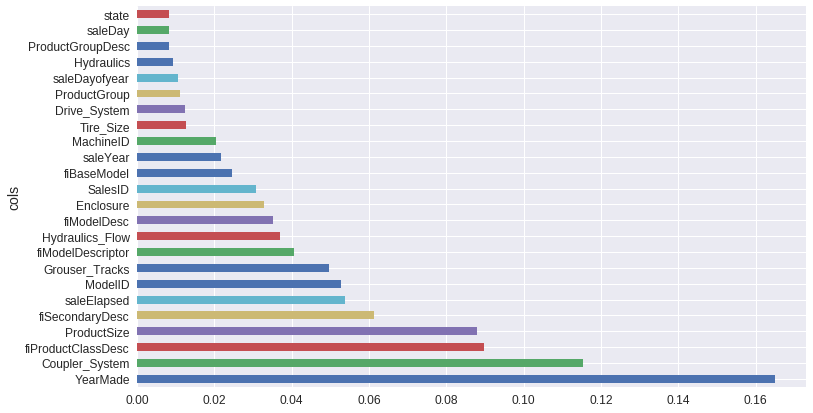

In [0]:
fi = rf_feat_importance(m,df_keep)
plot_fi(fi);

**Key thing that has happend is that when you remove redundant columns, you are also removing sources of collinearity.** In other words, two columns that might be related to each other. Collinearity does not make your random forest less predictive, but if you have a column A is a litte bit related to column B, and B is a stronger driver of independent, what happens is that the importance is going to split between A and B. By removing some of those columns with very little impact, it makes your feature importance plot clearer. Before YearMade was pretty close to Coupler_System. But there must be have been a bunch of things that are collinear with YearMade and now you can see YearMade really matters. This feature importance plot is more reliable than the one before because it has a lot less collinearity to confuse us.

**Let's talk about how this works** [1:17:21](https://youtu.be/YSFG_W8JxBo?t=1h17m21s)

Not only it is really simple, it is a technique you can use not just for random forests but for basically any kind of machine learning model. Interestingly almost no one knows this. Many people will tell you there is no way of interpreting this particular kind of model ( the most important interpretation of a model is knowing which things are important) and that is almost certainly not going to be true because the technique I am going to teach you actually works for any kind of models. 

![alt text](https://cdn-images-1.medium.com/max/800/1*bM9bFy4-xoEHoyciiBu95w.png)

- We take our bulldozer dataset and we have a column **Price** we are trying to predict ( dependent variable).
- We have 25 independent variables and one of them is **YearMade**.
- How do we figure out how important **YearMade** is? We have a whole random forest and we can find out our predictive accuracy. So we will put all these rows through our random forest, and it will spit out some predictions. We will then compare them to the actual price ( in this case , we get our root mean squared error and $R^2$). This is our starting point.
- Let's do exactly the same thing, but this time, take the **YearMade** column and randomly shuffle it (i.e randomly permute just that column). Now **YearMade** has exactly the same distribution as before (same mean, same standard deviation). But it has no relationships with our dependent variable at all because we totally randomly reordered it. 
- Before, we might have found our $R^2$ was 0.89. After shuffle YearMade, we check again, and now $R^2$ is 0.80. The score got much worse when we destroyed that variable.
- Okay, let's try again. We put YearMade back to how it was, and this time let's take Enclosure and shuffle that. This time, $R^2$ is 0.84 and we can say the amount of decrease in our score for YearMade was 0.09 and the amount of decrease for Enclosure was 0.05. An this is going to give us our feature importances for each column. 

**Question**: Can't we just exclude the column and check the decay in performance [1:20:31](https://youtu.be/YSFG_W8JxBo?t=1h20m31s)? You could remove the column and train a whole new random forest, but that is going to be really slow. Where else this way, we can keep our random forest and just test the predictive accuracy of it again. So this is nice and fast by comparison. In this case, we just have to rerun every row forward through the forest for each shuffled column. 

**Question**: If you want to do multi-collinearity, would you do two of them and random shuffle and then three of them [1:21:12]? I don't think you mean multi-collinearity, I think you mean looking for interaction effects. So if you want to say which pairs of variables are the most important, you could do exactly the same thing each pair in turn. In practice, there are better ways to that because that is obviously computationally expensive and so we will try to find time to do what if we can.

We now have a model which is a little bit more accurate and we have learned a lot more about it. So we are out of time and what I would suggest you try doing now before next class for this bulldozer dataset , is going through the top 5 or 10 predictors and try and learn what you can about how to draw plots in Pandas and try to come back with some insights about things like:
- What is the relationship between YearMade and the dependent variable
- what is the histogram of YearMade
- now that you know YearMade is really important, check if there is some noise in that column which we could fix
- Check if there is some weird encoding in that column we can fix.
- This idea Jeremy had that maybe Coupler_System is there entirely because it is collinear with something else, you might want to try and figure out if it's true. If so, how would you do it?
- fiProductClassDesc that rings alarm bells - it sounds like it might be a high cardinality categorical variable. It might be something with lots and lots level because it sounds like it is a model name. So go and have a look at that model name- does it have some order into it? Could you make it an ordinal variable to make it better? Does it have some kind of hierachical structure in the string that we can split it on hyphen to create more sub columns.



# LESSON 4

A Question before getting started: Could we summarize the relationship between the hyperparameters of the random forest and its affect on overfitting, dealing with collinearity, etc? [1:52](https://youtu.be/0v93qHDqq_g?t=1m51s). Absolutely. Going back to the lesson 1 notebook.

Hyperparameters of interest:

**1. set_rf_samples**

- Determines how many rows are in each tree. So before we start a new tree, we either boostrap a sample (i.e sampling with replacement from the whole thing) or we pull out a subsample of a smaller number of rows and then we build a tree from there.
- Step 1 is we have our whole big dataset, we grab a few rows at random from it, and we turn them into a smaller dataset. From that, we build a tree.

![alt text](https://cdn-images-1.medium.com/max/800/1*sOceYZ4t5xz3CCrxGSlYCg.png)

- Assuming that the tree remains balanced as we grow it, how many layers deep will this tree be (assuming we are growing it until every leaf is of size one)? log2(20000). The depth of the tree doesn't actually vary that much depending on the number of samples because it is related to the log of the size. 
- Once we go all the way down to the bottom, how many leaf nodes would there be? 20k. **We have a linear relationship between the number of leaf nodes and the size of the sample. So when you decrease the sample size, there are less final decisions that can be made**. Therefore, the tree is going to be less rich in terms of what it can predict because it is making less different individual decisions and it also is making less binary choices to get to choose decisions. 
- **Setting RF samples lower is going to mean that you overfit less, but it also means that you are going to have a less accurate individual tree model.** The way Breiman, the inventor of random forest, described this is that you are trying to do two things when you build a model with bagging. One is that each individual tree/estimator is as accurate as possible ( so each model is a strong predictive model). But then the across the estimators, correlation between them is as low as possible so that when you average them out together, you end up with something that generalizes. By decreasing the set_rf_samples number, we are actually decreasing the power of the estimator and increasing the correlation -- so is that going to result in a better or worse validation set result for you? It depends. This is kind of compromise which you have to figure out when you do machine learning models. 
    - A question about **oob_score=True** [6:47](https://youtu.be/0v93qHDqq_g?t=6m46s). All oob_score=True does is it says whether you subsample is (it might be a boostrap sample or a subsample), take all of the other rows (for each tree), put them into a different dataset, and calculate the error on those. So it doesn't actually impact training at all. It just gives you an additional metric which is the OOB error. So if you don't have a validation set, then this allows you to get kind of a quasi validation set for free.
    - Question : If you don't do set_rf_samples, what would it be called?[7:55](https://youtu.be/0v93qHDqq_g?t=7m55s) The default is, if you say reset_rf_samples, that causes it to boostrap, so it will sample a new dataset as big as the original one but with replacement. 
- **The second benefit of set_rf_samples** is that you can run more quickly [8:28](https://youtu.be/0v93qHDqq_g?t=8m28s). Particularly if you are running on a really large dataset like a hundred million rows, it will not be possible to run it on the full dataset. So you would either have to pick a subsample yourself before you start or you set_rf_samples.

**2. min_samples_leaf** [8:48](https://youtu.be/0v93qHDqq_g?t=8m48s)

Before, we assumed that **min_samples_leaf = 1**, if it is set to 2, the new depth of the tree is log2(20000)-1. Each time we double the min_samples_leaf, we are removing one layer from the tree, and halving the number of leaf nodes (i.e 10k). The result of increasing min_samples_leaf is that now each of our leaf nodes has more than one thing in, so we are going to get a more stable average that we are calculating in each tree. We have a little less depth (i.e we have less decisions to make) and we have a smaller number of leaf nodes. So again, we would expect the result of that node would be that each estimator would be less predictive, but the estimators would be also less correlated. So this might help us avoid overfitting. 

**Question**: I am not sure if every leaf node will have exactly two nodes [10:33](https://youtu.be/0v93qHDqq_g?t=10m33s). No it won't necessarily have exactly two. The sample of uneven split such as a leaf node containing 100 items is when they are all the same in terms of the dependent variable ( suppose either, but much more likely would be the dependent). So if you get to a leaf node where every single one of them has the same auction price, or in classification every single one of them has the same auction price, or in classification every single one of them is a dog, then there is no split that you can do that's going to improve your imformation. **Remember, information is the term we use in a general sense in random forest to describe the amount of difference about the additional information we create from a split is how much we are improving the model.** So you will often see this word information gain which means how much better the model got by adding an additional split point, and it could be based on RMSE or cross-entropy or how different to the standard deviation, etc.

So that is the second thing that we can do. It's going to speed up our training because it has one less set of decisions to make. Even though there is one less set of decisions, those decisions have as much as the previous set. So each layer of the tree can take twice as long as the previous layer. So it could definitely speed up training and generalize better. 

**3. max_features** [12:22](https://youtu.be/0v93qHDqq_g?t=12m22s)

At each split, it will randomly sample columns ( as opposed to **set_rf_samples** pick a subset of rows for each tree). It sounds like a small difference but it's actually quite a different way of thinking about it. We do set_rf_samples so we put out our sub-sample or a boostrap sample and that's kept for the whole tree and we have all of the columns in there. With max_features = 0.5, at each split, we'd pick a different half of the features. The reason we do that is because we want the trees to be as rich as possible. Particularly, if you were only doing a small number of trees (e.g 10 trees) and you picked the same column set all the way through the tree, you are not really getting much variety in what kind of things it can find. So this way, at least in theory, seems to be something which is going to give us a better set of trees by picking a different random subset of features at every decision point. 

The overall effect of the max_feature is the same -- it's going to mean that each individual tree is probably going to be less accurate but the trees are going to be more varied. In particular, here this can be critical because imagine that you got one feature that is just super predictive. It's so predictive that every random subsample you look at always starts out by splitting on that same feature that the trees are going to be very similar in the sense they all have the same initial split. But there may be some other interesting intial splits because they create different interactions of variables. So by half the time that feature won't even be available at the top of the tree, at least half the tree are going to have a different initial split. It definitely can give us more variation and therefore it can help us to create more generalized trees that have less correlation with each other even though the individual trees probably won't be as predictive.

![alt text](https://cdn-images-1.medium.com/max/800/1*pNJFdOz5_WHTpon_z9fvZQ.png)

In practice, as you add more trees, if you have max_features = None, that is going to use all the features everytime. Then with very few trees, that can still give you a pretty good error. But as you create more few trees, it's not going to help as much because they are all pretty similar as they are all trying every single variable. Where else, if you say max_features = sqrt or log2, then as we add more estimators, we see improvement so there is an interesting interaction between those two. The chart above is from scikit-learn docs.

**4. Things which do not impact our training at all** [16:32](https://youtu.be/0v93qHDqq_g?t=16m32s)

- n_jobs = -1 : simply specifies how many GPU or cores we run on, so it'll make it faster up to a point. Generally speaking, making this more than 8 or so, they may have diminishing returns. -1 says use all of your cores. It seems weird that the default is to use one core. You will definitely get more performance by using more cores because all of you have computers with more one core nowadays.

- oob_score= True: this simply allows us to see OOB score. If you had set_rf_samples pretty small compared to a big dataset, OOB is going to take forever to calculate. Hopefully at some point, we will be able to fix the library so that doesn't happen. There is no reason that need to be that way, but right now, that's how the library works.

So they are our key basic parameters we can change [17:38](https://youtu.be/0v93qHDqq_g?t=17m38s). There are more that you can see in docs or shift+tab to have a look at them, but the one you 've seen are the ones that I've found useful to play with so feel free to play with others as well. Generally speaking, these values work well:
- max_features: None, 0.5, sqrt, log2
- min_samples_leaf : 1,3,5,10,25,100... As you increase, if you notice by the time you get to 10, it's already worse then there is no point to going further. If you get to 100 and it's still going better, then you can keep trying.



    
           

# Random Forest Interpretation (Cont) [18:50](https://youtu.be/0v93qHDqq_g?t=18m50s)

Random forest interpretation is something which could use to create some really cool Kaggle kernels. Confidence based on tree variance is something which does'nt exist anywhere else. Feature importance definitely does and that's already in quite a lot of Kaggle kernels. If you are looking at a competition or a dataset where nobody's done feature importance, being the first person to do that is always going to win lots of votes because the most important thing is which features are important. 

**Confidence based on tree variance** [20:43](https://youtu.be/0v93qHDqq_g?t=20m43s) 

As I mentioned, when we do model interpretation, I tend to set_rf_samples to some subset -- something small enough that I can run a model in under 10 seconds because there is no point running a super accurate model. 50,000 is more than enough to see each time you run an interpretation, you'll get the same results back and so as long as that's true, then you are already using enough data. 

In [0]:
set_rf_samples(50000)

m =RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                        n_jobs=-1, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20681226070714404, 0.24414487278512412, 0.9106103184536648, 0.8935506067286472, 0.8942382781808567]


**Feature importance** [21:14](https://youtu.be/0v93qHDqq_g?t=21m14s)

We learnt it works by randomly shuffling a column, each column one at a time, then seeing how accurate the pre-trained model is when you pass that in all the data as before but with one column shuffled.

Some of the questions I got after class reminded me that it is very easy to under appreciate how powerful and magic this approach is. To explain, I'll mention a couple of the questions I heard. 

- **One question** was " what if we just took one column at a time, and created a tree on just that column ". Then we will see which column's tree is the most predictive. Why may that give misleading results about feature importance?
    - We are going to lose the interactions between the features. If we just shuffle them, it will add randomness and we are able to both capture the interactions and the importance of feature. This issue of interaction is not a minor detail. It is massively important. Think about this bulldozers datasets where, for example, there is one field called "YearMade" and another field called  "SaleDate". If we think about it, it's pretty obvious that what matters is the combination of these two. In other words, the difference between the two is how old the piece of the equipment was when it got sold. So if we only included one of these, we are going to massively underestimate how important that feature is. 
    - Now, here is a really important point though. It's pretty much always possible to create a simple logistic regression which is as good as pretty much any random forest if you know ahead of time exactly what variables you need, exactly how they interact, exactly how they need to be transformed. In this case, for example, we could have created a new field which was equal to SaleYear-YearMade and we could have fed that to a model and got that interaction for us. But the point is, we never know that. You might have guess of it-- I think some of these things are interacting in this way, and I think this thing we need to take the log, and so forth. But the truth is that the way the world works, the casual structures, they have many many things interacting in many many subtle ways. That's why using trees, whether it be gradient boosting machines or random forests, work so well.
    
- **Terrance's comment:** One thing that bit me years ago was also tried doing one variable at a time thinking "oh well, I'll figure out which one's most correlated with the dependent variable" [24:45](https://youtu.be/0v93qHDqq_g?t=24m45s). But what it doesn't pull apart is that what if all variables are basically copied the same variable then they are all going to seem equally important but in fact it's really just one factor. 

That is also true here. If we had a column appear twice, then shuffling that column isn't going to make the model much worse. If you think about how it's build, particularly if we had max_features = 0.5, some of the times, we are going to get version A of the column , some of the times, we are going to get version B of the column. So half of the time, shuffling version A of the the column is going to make a tree a bit worse, half the time it's going to make column B it'll make a bit worse, so it'll show that both of those features are somewhat important. And it will share the importance between the two features. So this is why " collinearity" ( I write collinearity but it means that they are linearly related , so this isn't quite right) -- but this is why having two variables that are closely related to each other or more variables that are closely related to each other, means that you will often underestimate their importance using this random forest technique. 

- **Question**: Once we've shuffled and we get a model, what exactly are the units of these importance? Is this a change in $R^2$? [26:26](https://youtu.be/0v93qHDqq_g?t=26m26s) It depends on the library we are using. So the units are kind of like.. I never think about them. I just know that in this particular library, 0.005 is often a cutoff I would tend to use. But all I actually care about is this picture( the feature importance ordered for each variable):

![alt text](https://cdn-images-1.medium.com/max/800/1*Xnqj8amyVJAvl2XJzORkNQ.png)

Then zooming in, turning it into bar plot and then find where it becomes flat(~0.005).

![alt text](https://cdn-images-1.medium.com/max/800/1*3LZIsZH4c02U0Moz2XZOGA.png)

So I removed them at that point and check the validation score didn't get worse.

`to_keep = fi[fi.imp>0.005].cols ; len(to_keep)`

**If i did get worse, I will just decrease the cutoff a little bit** until it doesn't get worse. So the units of measure of this don't matter too much. We will learn later about a second way of doing variable importance, by the way.

**What is the purpose of removing them?** [27:42](https://youtu.be/0v93qHDqq_g?t=27m42s) Having looked at our feature importance plot, we see the ones less than 0.005 is this long tail of boringness. So I said let's just try grabbing the columns where it is greater than 0.005, create a new dataframe call df_keep which is df_train with just those kept columns, create a new training and validation sets with just those columns, create a new random forest, and look to see how the validation set score. And the validation set RMSE changed and they got a bit better. So if they are about the same or a tiny bit better then my thinking is well this is just a good model, but it's now simpler.

So when I redo the feature importance, there is less collinearity. In this case, I saw that YearMade went from being a bit better than the next best thing (Coupler_System), but now it's way better. So I did seem to definitely change these feature importances and hopefully give me some insight there. 

![alt text](https://cdn-images-1.medium.com/max/800/1*poOuP2raIO1Y6nS0guMsaA.png)

**Question**: So how did that help our model [29:30](https://youtu.be/0v93qHDqq_g?t=29m30s)? We are going to dig into that now. Basically it tells us that, for example, if we are looking for how we are dealing with missing value, is there noise in the data, if it is a high cardinality categorical variable, -- they are all different steps we would take. 
- **if it was a high cardinality categorical variable** that was originally a string, maybe fiProductClassDesc in above case, I remember one of the ones we looked at the other day had first of all was the type of vehicle and then a hyphen, and then the size of the vehicle. We might look at that and say " okay, that was an important column. Let's try splitting it into two on hyphen and take that bit which is a size of it and parse it and convert it into an interger". We can try and do some feature engineering. Basically until you know which ones are important, you don't know where to focus that engineering time. You can talk to your client or folks that are responsible for creating this data. If you were actually working at a bulldozer auction company, you might now go to the actual auction company, you might now go to the acutual auctioneers and say " I am really surprised that Coupler_Systems". So frankly this is actually not telling you about Coupler_System but about something else. Oh hey, that reminds me, that's something else we actually have measured that. It is in this different CSV file. I'll go get it for you" . So it helps you focus your attention. 

**Question**: So I had a fun little problem this weekend as you know. I introduced a couple of crazy computation into my random forest and all of a sudden they're like oh my god these are the most important variables ever squashing all of the others. But then I got a terrible score and then is that because now that I think I have my scores computed correctly , what I noticed is that the important went through the roof but the validation set was still bad or got worse. Is that because somehow that computation allow the training to almost like an identifier map exactly what the answer was going to be for training but of course that doesn't generalize to the validation set. I that what I observed [31:33](https://youtu.be/0v93qHDqq_g?t=31m33s)? There are two reasons why your validation score might bot be very good.

![alt text](https://cdn-images-1.medium.com/max/800/1*M4VuX7euiQB6y3Urufhzeg.png)

So we got these 5 numbers: RMSE of training, validation, $R^2$ of the training, validation, and $R^2$ of OOB. There are two reasons and really in the end what we care about for this Kaggle competition is the RMSE of the validation set assuming we've created a good validation set. So Terrance 's case, he is saying that RMSE of the validation got worse when he did some feature engineering. Why is that? There are two possible reasons:
- Overfitting. If you are overfitting, then your OOB will also get worse. If you are doing a huge data with a small set_rf_samples so you can't use an OOB, then instead create a second validation set which is a random sample and do that. So in other words,**if your OOB or your random sample validation set has gotten much worse then you must be overfitting.** I think in your case, Terrance, it 's unlikely that's the problem because random forests don't overfit that badly. It's very hard to get them to overfit that badly unless you use some really weird parameters like only one estimator, for example. Once we've got ten trees in there, there should be enough variation that you can definitely overfit but not so much that you're going to destroyu your validation score by adding a variable. So I'd think you 'll find that's probably not the case, but it's easy to check. And if it's not the case, then you'll see that your OOB score or your random sample validation score hasn't gotten much worse.
- The second reason your validation score can get worse, **if your OOB score hasn't got worse, you 're not overfiting but your validation score has gotten worse that means you're doing somthing that is true in the training set but not true in the validation set**. So this can only happen when your validation set is not a random sample. For example, in this bulldozers competition or in the grocery shopping competition, we've intentionally made a validation set that is for a different date range -it's for the most recent two weeks. So if something different happend in the last two weeks to the previous weeks, then you could totally break your validation set. For example, if there was some kind of unique identifier which is different in the two date periods, then you can learn to identify things using that identifier in the training set. BUt then the last two weeks may have a totally different set of IDs or the different set of behavior, it could get a lot worse. What you are describing is not common though. So I'm a bit skeptical- it might be a bug but hopefully there's enough things can now use to figure out if it is a bug. We will be interested to hear what you learned.



**Feature importance (Cont): Linear regression, logistic regression** [36:01](https://youtu.be/0v93qHDqq_g?t=36m1s)

That's feature importance. I'd like to compare that to how feature importance is normally done in industry and in academic communities outside of machine learning, like in psychology, economies, and so forth. Generally speaking, people in those enviroments tend to use some kind of linear regression, logistic regression, general linear models. They start with their dataset and they say I am going to assume that I know the kind of parametric relationship between my independent variables and my dependent variable. So I'm going to assume that it's a linear relationship or a linear relationship with a link function like a sigmoid to create logistic regression. So assuming I already know that, I can now write this an equation. So if you have x1, x2, so forth. 

![alt text](https://cdn-images-1.medium.com/max/800/1*uyH9A-FZLq-xGaRjRye4WQ.png)

I can say my y values are equal to ax1 + bx2 = y, therefore I can find out the feature importance easily enough by just looking at these coefficients and see which one is the highest, particularly if you have normalized the data first. There is this trop out there that is very common is that this is somehow more accurate, more pure , **in some way better way of doing feature importance but that couldn't be farther from the truth**. If you think about it, if you were missing an interaction, if you were missing a transformation you needed, or if you have any way being anything less than a 100% perfect in all of your preprocessing so that your model is the absolute correct truth of the situation-unless you've got all of that correct, the your coefficients are wrong. Your coefficients are telling you " in your totally wrong model, this is how important those things are" which is basically meaningless. Where else, the random forest feature importance is telling you in this extremely high parameter, highly flexible functional form, with few if any statistical assumptions, this is your feature importance. So I would be very cautious. 

Again, I can't stress this enough when you leave this program, you are much more often going to see people talk about logistic regression coefficients than you are doing to see them talk about random forest variable importance. And everytime you see that happen, you should be very very skeptical of what you are seeing. Anytime you read a paper in economics or in psychology, or the marking department tells you that this regression or whatever, every single those coefficients are going to be massively biased by any issues in the model. Furthermore, if they're done so much pre-processing that actually the model is pretty accurate then now you are looking at coeffiecients that are going to be like a coefficient of some princial component from a PCA or a coefficient of some distance from some cluster or something. At which point, they are very very hard to interpret anyway. They are not actual variables. So they are kind of two options I've seen when people try to use classic statistical techniques to do a variable importance equivalent. I think things are starting to change slowly. These are some fields that are starting to realize that this is totally the wrong way to do things. But it's been nearly 20 years since random forests appeared so it takes a long time. People say that the only way that knowledge really advances is when the previous generation dies, and that's kind of truth. Particular academics, they make a career of being good at a particular sub thing and often it's not until the next generation comes along that people notice that's actually no longer a good way to do things. And I think that's what happened here.

We've got now a model which isn't really any better predictive accuracy wise, but we are getting a good sense that there seems to be four main important things [40:38](https://youtu.be/0v93qHDqq_g?t=40m38s): YearMade, Coupler_System, ProductSize, fiProductClassDesc.



#One hot encoding [41:00](https://youtu.be/0v93qHDqq_g?t=41m)

There is something else that we can do, however, which is we can do something called one hot encoding. So this is going to where we talking about categorical variable. Remember, a categorical variable, let's say we had a string high, low, medium (the order we got was kind of weird - in alphabetical order by default). So we mapped it to 0,1,2. By the time it gets into our dataframe, it's now a number so the random forest doesn't know that it was originally a category - it's just a number. So when the random forest is built, it basically says oh it is greater than 1 or not. Or it is greater than naught or not. They are basically the two possible decisions it could have made. For some thing with 5 or 6 bands, it could be that just one of the levels of category is actually interesting. Maybe the only thing that mattered was whether it was unknown. Maybe not knowing its size somehow impact the price. So if we wanted to be able to recognize that and particularly if it just so happend that the way that the numbers were coded , was it unknown ended up in the middle, then it 's going to take two splits to get to the point where we can see that it's actually unknown that matters. So this is a little inefficient and we're wasting tree computation. Wasting tree computation matters because everytime we do a split, we are halving the amount of data at least that we have to do more analysis. So it's going to make our tree less rich and less effective if we are not giving the data in a way that is convenient for it to do the work it needs to do.

What we could do instead is create 6 columns for each category and each column would contain 1's and 0's. Having added 6 additional columns to our dataset, the random forest now has the ability to pick one of these and say oh, let's have a look at is_unknow. **There is one possible fit I can do which is 1 vs 0. Let's see that's any good. So it now has the ability in a single step to pull out a single category level and this kind of coding is called one-hot encoding**. For many types of machine learning model, something like this is necessary. If you are doing logistic regression, you can't possibly put in a categorical variable that goes naught through give because there is obviously no written linear relationship between that and anything. So one-hot encoding, alot of people incorrectly assume that all machine learning requires one-hot encoding. But in this case, I'm going to show you how we could use it optionally and see whether it might improve things sometimes. 

**Question**: If we have six categories like in this case, would there be any problems with adding a column for each of the categories? In linear regression, if there are six categories, we should only do it for five of them. [45:17](https://youtu.be/0v93qHDqq_g?t=45m17s). You certainly can say let's not worry about adding is_medium because we can infer it from the other five. I would say include it anyway because otherwise, the random forest has to make five decisions to get to that point. The reason you need to not include one in linear models is because linear models hate collinearity but we don't care about that here.

So we can do one-hot encoding easily enough and the way we do it is we pass one extra parameter to **proc_df** which is the max number of categories (**max_n_cat**). So if we say it's seven, the anything with less than seven levels is going to be turned into a one-hot encoded bunch of columns.


In [0]:
df_trn2,y_trn,nas = proc_df(df_raw,'SalePrice',max_n_cat=7)
X_train,X_valid = split_vals(df_trn2,n_trn)

In [0]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                          max_features=0.6, n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20740391464078425, 0.2529228238688011, 0.9100981301736023, 0.8857584680974512, 0.8923743190864362]


Like zip code has more than six levels so that would be left as a number. Generally speaking, you obviously probably wouldn't want to one-hot encode zip code because that's just going to create masses of data, memory problems, computation problems, and so forth. So this is another parameter you play around with.

So if I try it out, run the random forest as per usual, you can see what happens to the $R^2$ of the validation set and to the RMSE of the validation set. **In this case, I found it got a little bit worse. This isn't always the case and it's going to depend on your dataset. It depends on if you have a dataset where single categories tend to be quite important or not. In this particular case, I did not make it more predictive. However, what it did do is that we now have different features**. proc_df puts the name of the variable, an underscore, and the level name. So interestingly, it turns out that before, it said that **Enclosure** was somewhat important. When we do it as one-hot encoded, it actually say **Enclosure_EROPS w AC** is the most important thing. So for at least the purpose of interpreting your model, you should always try one-hot encoding quite a few of your variables. I often find somewhere around 6 or 7 pretty good. You can try making that number as high as you can so that it doesn't take forever to compute and the feature importance doesn't include really tiny levels that aren't interesting. It clearly tells me I need to find out what **Enclosure_EROPS w AC** is and why it is important because it means nothing to me right now but it is the most important thing. So I should go figure that out.

![alt text](https://cdn-images-1.medium.com/max/800/1*1TGQ27rxZwV4w56CMpxB-Q.png)

**Question**: Can you explain how changing the max number of category works? Because for me, it just seems like there are 5 categories or 6 categories [49:15](https://youtu.be/0v93qHDqq_g?t=49m15s).Here are columns called zip code, usage band and sex, for example. Say, zip code has 5000 levels. The number of levels in a category, we call its "cardinality". So it has cardinality of 5000. Usage band may have a cardinality of six. Sex has cardinality of two. So when proc_df goes through and says okay, this is a categorical variable, should I one-hot encode it? It checks the cardinality against max_n_cat and says 5000 is bigger than 7 so I don't one-hot encode it. Then it goes to usage band - 6 is less than 7, so I do one-hot encode. It goes to sex, and 2 less than 7 , so one-hot encode that too. So it just says for each variable, how I decide whether done one-hot encode it or not. Once we decide to one-hot encode it, it does not keep the original variable.

If you have actually made an effort to turn your ordinal variables into proper ordinals , using proc_df can destroy that. The simple way to avoid that is if we know that we always want to use the codes for usage band, you could just go ahead and replace it:

![alt text](https://cdn-images-1.medium.com/max/1000/1*YYRvctyOdwzyAA0dubXfCg.png)

Now it's an integer. So it will never get changed.


**Example:** the column ProductSize which has 6 categories:

- Large
- Large / Medium
- Medium
- Compact
- Small
- Mini

gets turned into 6 new columns:

- ProductSize_Large
- ProductSize_Large / Medium
- ProductSize_Medium
- ProductSize_Compact
- ProductSize_Small
- ProductSize_Mini
and the column ProductSize gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the max_n_cat argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

#Removing redundant features [54:57](https://youtu.be/0v93qHDqq_g?t=54m57s)

We've already seen how variables which are basically measuring the same thing can confuse our variable importance. They can also make our random forest slightly less good because it requires more computation to do the same thing and there're more columns to check. So we are going to do some more work to try and remove redundant features. The way I do that is to do something called **"dendrogram"**. And **it is kind of hierarchical clustering.**

**Cluster analysis** is something where you are trying to look at objects, they can be either rows in the dataset or columns and find which ones are similar to each other. Often you will see people particularly taking about cluster analysis, they normally refer to rows of data and they will say "let's plot it" and find the clusters. A common type of cluster analysis, time permitting, we may get around to talking about this in some detail, is called k-means. It is basically where assume that you don't have any labels at all and you take a couple of data points at random and you gradually find the ones that are near to it and move them closer and closer to centroids, and you may repeat it again and again. It is an iterative approach that you tell it how many clusters you want and it will tell you where it thinks that classes are. 

A really under used technique (20 or 30 years ago it was much more popular than it is today) is a hierarchical clustering also known as agglomerated clustering. In hierarchical or agglomerated clustering, we look at every pair of objects and say which two objects are the closest. We then take the closest pair, delete them and replace them with the midpoint of the two. Then repeat that again and again. Since we are removing the points and replacing them with their averages, you are gradually reducing a number of points by pairwise combining. The cool thing is, you can plot that. 



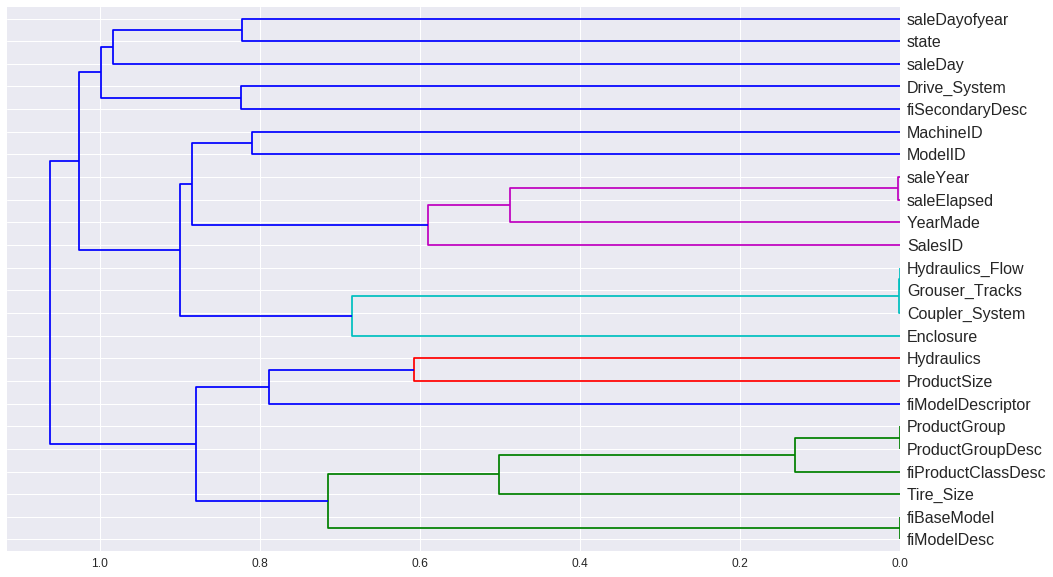

In [0]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,6))
dendrogram = hc.dendrogram(z,labels = df_keep.columns,
                        orientation='left',leaf_font_size=16)
plt.show()

Like so. Rather than looking at points, you look at variables and we can see which two variables are the most similar. **saleYear** and **saleElapsed** are very similar. So the horizontal axis here is how similar are the two points that are being compared. If they are closer to the right, that means that they are very similar. So saleYear and saleElapsed have been combined and they were very similar. 

In this case, I actually use Spearman's R. You guys familiar with correlation coefficients already? So correlation is almost exactly the same as the $R^2$, but it's between two variables rather than a variable and its prediction. The problem with a normal correlation is that if you have data that look like this then you can do a correlation and you'll get a good result.

![alt text](https://cdn-images-1.medium.com/max/600/1*dObn_o4F0-bWOGtdAkajkA.png =200x200)

But if you've got data which looks like this and you try and do a correlation (assuming linearity), that's not very good. 

![alt text](https://cdn-images-1.medium.com/max/600/1*MBizy1nyW_8LP5I2xhrhNw.png =200x200)

So there is a thing called a rank correlation which is a really simple data. Replace every point by its rank. 

![alt text](https://cdn-images-1.medium.com/max/600/1*ETf92aZgRGcdhXCkSPQ70w.png)

From left to right, we rank from 1, 2, ...6. Then you do the same for y-axis. Then you create a new plot where you don't plot the data but you plot the rank of the data. If you think about it, the rank of this dataset is going to look like an exact line because every time something was greater on the x-axis , it was also greater on y-axis. So if we do a correlation on the rank, that's called a rank correlation.

Because we want to find the columns that are similar in a way that the random forest would find them similar (random forests do not care about linearity, they just care about ordering), so a rank correlation is the right way to think about that [1:00:05](https://youtu.be/0v93qHDqq_g?t=1h5s). So Sprearman's R is the name of the most common rank correlation. But you can literally replace the data with its rank and chuck it at the regular correlation and you will get basically the same answer. The only difference is in how ties are handled which is a pretty minor issue. 

One we have a correlation matrix, there is basically a couple of standard steps you do to turn that into a dendrogram which I have to look up on stackoverflow each time I do it. You basically turn it into a distance matrix and then you create somthing that tells you which things are connected to each other things hierarchically. So **these are three standard steps you always have to do to create a dendrogram**:



```
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method ='average')
dendrogram = hc.dendrogram(z, labels = df_keep.columns,
                               orientation='left', leaf_font_size=16)
```

Then you can plot it [1:01:30](https://youtu.be/0v93qHDqq_g?t=1h1m30s). **saleYear and saleElapsed** are measuring basically the same thing ( at least in terms of rank) which is not surprising because saleElapsed is the number of days since the first day in my dataset so obviously these two are nearly entirely correlated. **Grouser_Tracks, Hidraulics_Flow, and Coupler_System** all seem to be measuring the same thing. This is interesting because remember, Coupler_System it said was super important. So this rather supports our hypothesis there is nothing to do with whether it's a coupler system but whether it is whatever kind of vehicle it is has these kind of features. **ProductGroup and ProductGroupDesc** seems to be measuring the same thing, and so are **fiBaseModel and fiModelDesc**. Once we get past that, suddenly things are further away, so I'm probably going to not worry about those. So we are going to look into those four groups that are very similar. 

![alt text](https://cdn-images-1.medium.com/max/600/1*w2rwHdd6x6h3B1Upo0PbpA.png =300x200)

If you just want to know how similar is this thing to this thing, the best way is to look at the Spearman's R correlation matrix [1:03:43](https://youtu.be/0v93qHDqq_g?t=1h3m43s). There is no random forest being used here. The distance measure is being done entirely on rank correlation. 

What I then do is I take these groups and I create a little function **get_oob** ( get Out Of Bank score) [1:04:29](https://youtu.be/0v93qHDqq_g?t=1h4m29s). It does a random forest for some dataframe. I make sure that I have taken that dataframe and split it into a training and validation set, and then I call fit and **return** the OOB score. 


In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators = 30, min_samples_leaf = 5, 
                              max_features = 0.6, n_jobs=-1,oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x,y_train)
    return m.oob_score_

Basically what I'm going to do is try removing each one of these 9 or so variables one at a time and see which ones I can remove and it doesn't make the OOB score get worse. 

In [0]:
get_oob(df_keep)

0.8904613809719674

And each time I run this, I get slightly different results so actually it looks like the last time I had 6 things and not 9 things. So you can see, I just do a loop through each of the things that I am thinking maybe I can get rid of this because it's redundant and I print out the column name and the OOB score of a model that is trained after dropping that one column.

In [0]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 
          'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c,axis=1)))

saleYear 0.8889405031362174
saleElapsed 0.8862214186565637
fiModelDesc 0.8892739947437236
fiBaseModel 0.8885516430233312
Grouser_Tracks 0.8904965179993006
Coupler_System 0.8903073973504337


The OOB score on my whole dataframe is 0.89 and then after dropping each one of these things, basically none of them got much worse. **saleElapsed** is getting quite a bit worse than **saleYear**. Burt it looks like pretty much everything else, I can drop with only like a third decimal place problem. So obviously though, you've got to remember the dendrogram. Let's take fiModelDesc and fiBaseModel, they are veyr similar to each other. So what this says isn't that I can get rid of both of them, I can get rid of one of them because they are basically measuring the same thing.

So then I try it. Let's try getting rid of one from each group:

In [0]:
to_drop = ['saleYear','fiBaseModel','Grouser_Tracks']
get_oob(df_keep.drop(to_drop,axis=1))

0.8885105246451428

We've gone from 0.890 to 0.888 again, it's so close as to be meaningless. So that sounds good. **Simpler is better.** So I'm now going to drop these columns from my dataframe, and then I can try running the full model again.

In [0]:
df_keep.drop(to_drop,axis=1,inplace=True)
X_train, X_valid = split_vals(df_keep,n_trn)

os.makedirs('data/bulldozers/tmp',exist_ok=True)
np.save('data/bulldozers/tmp/keep_cols.npy',np.array(df_keep.columns))

keep_cols = np.load('data/bulldozers/tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

**reset_rf_samples** means I'm using my whole boostrapped sample. With 40 estimators, we got 0.907

In [0]:
reset_rf_samples()

m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,
                          max_features=0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.1258661201229744, 0.22731131656051937, 0.9668905080870213, 0.9077237177628024, 0.9084414548359437]


So I've now got a model which is smaller and simpler, and I'm getting a good score for. So at this point, I've now got rid of as many columns as I feel I comfortably can (ones that either didn't have a good feature important or were highly related to other variables, and the model didn't get worse significantly when I removed them.)

#Partial dependence [1:07:34](https://youtu.be/0v93qHDqq_g?t=1h7m34s)

So now I'm at the point where I want to try and really understand my data better by taking advantage of the model. And we are going to use something called partial dependence. Again, this is something that you could use in the Kaggle kernel and lots of people are going to appreciate this because almost nobody knows about partial dependence and it's very very powerful technique. What we are going to do is we are going to find out, for the features that are important, how do they relate to the dependent variable. Let's have a look.

In [0]:
!pip install pdpbox
!pip install scikit-misc

In [0]:
from pdpbox import pdp
from plotnine import *

Again since we are doing interpretation, we will set **set_rf_samples** to 50,000 to run things quickly

In [0]:
set_rf_samples(50000)

We'll take our dataframe, we will get our feature importance and notice that we are using max_n_cat because I am actually pretty interested in seeing individual levels for interpretation.

In [0]:
df_trn2,y_trn,nas = proc_df(df_raw,'SalePrice',max_n_cat=7)
X_train,X_valid = split_vals(df_trn2,n_trn)


In [0]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,
                          max_features= 0.6,n_jobs=-1)
m.fit(X_train,y_train);

Here is the top 10:

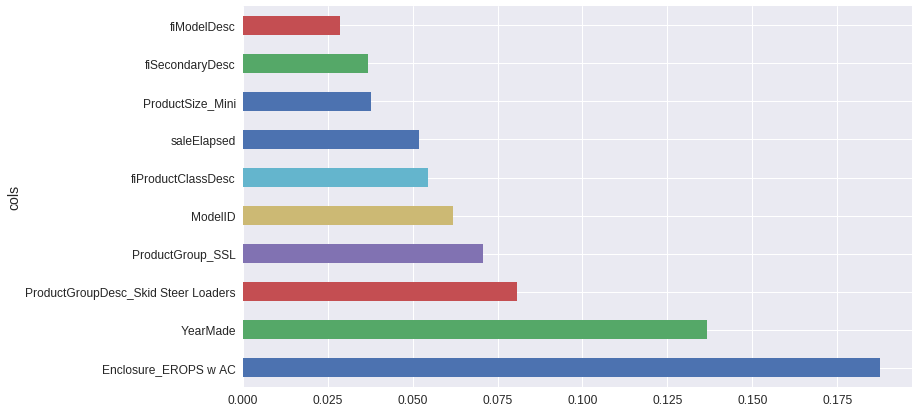

In [0]:
plot_fi(rf_feat_importance(m,df_trn2)[:10]);

Let's try to learn more about those 10. YearMade is the second most important. So one obvious thing we could do would be to plot YearMade against saleElapsed because as we've talked about already, it seems to make sense that they are both important but it seems very likely that they are combined together to find how old was the product when it was sold. So we could try plotting YearMade against saleElapsed to see how they relate to each other.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


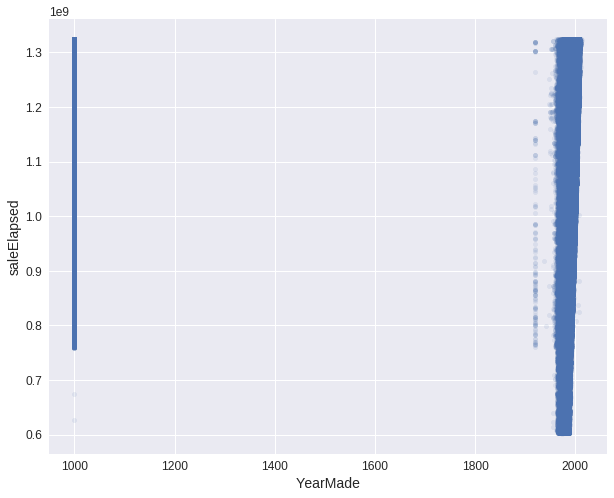

In [0]:
df_raw.plot('YearMade','saleElapsed','scatter',alpha=0.1,
           figsize=(10,8));

When we do, we get this very ugly graph [1:09:08](https://youtu.be/0v93qHDqq_g?t=1h9m8s). It shows us that YearMade actually has a whole bunch that are a thousand. Clearly, this is where I would tend to go back to the client and say okay, I'm guessing that these bulldozers weren't actually made in the year 1000 and they would presumably say to me " oh yes, they are ones where we don't know where it was made". Maybe "before 1986, we didn't track that" or maybe " the things that are sold in Illinois, we don't have that data provided", etc - they will tell us some reason. So in order to understand this plot better, I'm just going to remove them from this interpretation section of the analysis. We will just grab things where YearMade is greater than 1930.

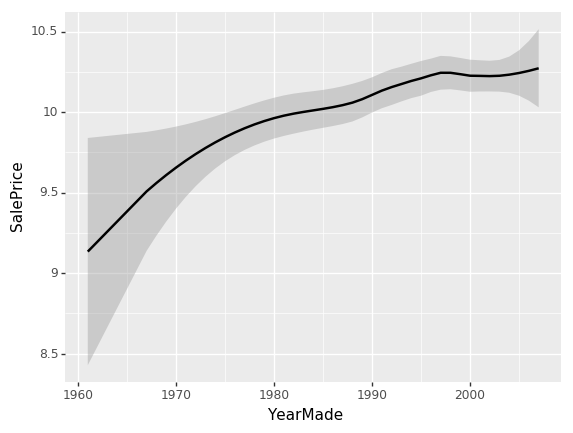

<ggplot: (-9223363244880811986)>

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930],500)

ggplot(x_all, aes('YearMade','SalePrice'))+stat_smooth(se=True,
                                                      method='loess')

Let's now look at the relationship between YearMade and SalePrice. There is really great package call ggplot. **ggplot originally was an R package (GG stands for the Gramma of Graphics)**. The grammar of graphics is this very powerful way of thinking about how to produce charts in a very flexible way. I'm not going to talking about it much in this class. There is lots of imformation available online. But I definitely recommend it as a great package to use. **ggplot** which you can pip install, it's part of the fast.ai enviroment already. ggplot in Python has basically the same parameters and API  as the R version. The R version is much better documented so you should read its documentation to learn how to use it. But basically you say " okay, I want to create a plot for this dataframe (x_all)". When you create plots, most of the datasets you are using are going to big to plot. For example, if you do a scatter plot, it will create so many dots that it's just a big mess and it will take forever. Remember, when you are plotting things, you are looking at it, so there is no point something with a hundred million samples when it you only used a hundred thousand , it's going to be pixel identical. That's why I cal get_sample first. get_sample just grabs a random sample.



```
ggplot(x_all,aes('YearMade','SalePrice'))+stat_smooth(se=True, method='loess')
```

So I'm just going to grab 500 points from my dataframe and plot YearMade against SalePrice. **aes** stands for "aesthetic" -- this is the basic way that you set up your columns in ggplot. Then there is this weird thing ggplot where "+" means add chart elements. So I'm going to add a smoother. Often you will find that a scatter plot is very hard to see what is going on because there's too much randomness. Or else, a smoother basically creates a little linear regression for every little subset of the graph. So it joins it up and allows you to see a nice smooth curve. That is the main way that I tend to look at univariate relationships. By adding standard error equals true (**se=True**), it also shows me the confidence interval of this smoother. **loess** stands for locally weighted regression which is this idea of doing lots of little mini regressions.


So you can see here[1:12:48](https://youtu.be/0v93qHDqq_g?t=1h12m48s), the relationship between YearMade and SalePrice is all over the place which is not really what we would expect. I would have expected that stuff that's sold more recently would probably be more expensive because of inflation and they are more current models. The problem is that when you look at a univariate relationship like this, there is a whold lot of collinearity going on- a whole lot of interactions that are being lost. For example, why did the price drop? It is actually because things are made between 1991 and 1997 are less valuable? Or it is actually because most of them were also sold during that time and there was maybe a recession then? Or maybe it was because products sold during that time, alot more people were buying types of vehicles that were less expensive? There's all kind of reasons for that. So again, as data scientists, one of the things you are going to keep seeing is that at the companies that you join, people will come to you with these kind of univariate charts where they'll say "oh my gosh, our sales in Chicago have disappeared. They got really bad." or " people aren't clicking on this anymore" and they will show you a chart that looks like this and ask what happened. Most of the time, you'll find the answer to the question "what happened" is that there is something else going on. So for instance, "actually in Chicago last week, actually we were doing a new promotion and that's why our revenue went down" -- it's not because people are not buying stuff in Chicago anymore; the prices were lower".

So what we really want to be able to do is say " well, what's the relationship between SalePrice and YearMade"all other things being equal". " All other things being equal" basically means if we sold everything in 1990 vs 1980 and it was exactly the same thing to exactly the same person in exactly the same auction so on and so forth, what would have been the difference in price? To do that, we do something called a **partial dependence plot** [1:15:02](https://youtu.be/0v93qHDqq_g?t=1h15m2s) 



In [0]:
x = get_sample(X_train[X_train.YearMade>1930],500)

There is a really nice library which nobody's heard of called **pdp** which does these partial dependece plots, and what happens in this. We've got our sample of 500 data points and we are going to do something really interesting. We are going to take each one of those five hundred randomly choosen auctions and we are going to make a little dataset out of it.

Here is our dataset of 500 auctions and here is our columns, one of which is the thing that we are interested in which is YearMade. We are now going to try and create a chart where we say all other things being equal in 1960, how much did things cost in auctions? The way we are going to do that is we are going to replace the YearMade column with 1960. We are going to copy in the value 1960 again and again all the way down. Now every row, the year made is 1960 and all of the other data is going to be exactly the same. Now every row, the YearMade is 1960 and all of the other data is going to be exactly the same. We are going to take our random forest, and pass all this through our random forest to predict the sale price. That will tell us for everything that was auctioned, how much do we think it would have been sold for if that thing was made in 1960. And that's what we are going to plot on the right.

![alt text](https://cdn-images-1.medium.com/max/800/1*pTwZXqXoN_N_ylwZB_UJBw.png =400x300)

And we are going to do the same thing for 1961.

**Question**: To be clear, we've already fit the random forest and then we are just passing a new year and seeing what it determines the price should be [1:17:10](https://youtu.be/0v93qHDqq_g?t=1h17m10s)? Yes, so this is a lot like the way we did feature importance. But rather than randomly shuffling the column, we are going to replace the column with a constant value. Randomly shuffling the column tells us how accurate it is when you don't use that column anymore. Replacing the whole column with a constant estimates for us how much we would have sold that product for in that auction on that day in that place if that product had been made in 1961. We then take the average of all the sale prices that we calculate from that random forest. We do it in 1961 and we get this value:

![alt text](https://cdn-images-1.medium.com/max/800/1*LN9YPxK8p0CvKBRo6fU6SQ.png =400x300)

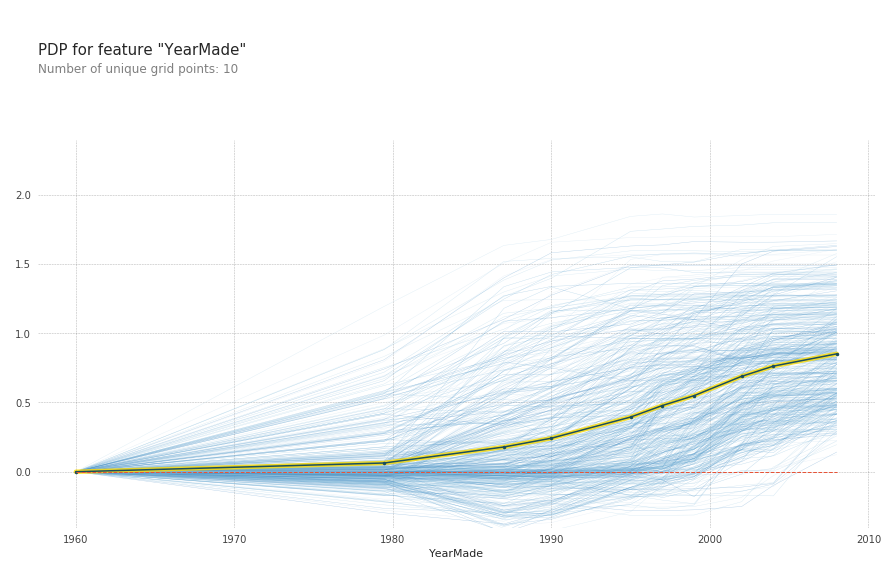

In [0]:
def plot_pdp(feat,clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m,x,x.columns,feat)
    return pdp.pdp_plot(p, feat_name,plot_lines=True,
                       cluster=clusters is not None,
                       n_cluster_centers=clusters)

plot_pdp('YearMade');

So what the partial dependence plot(PDP) here shows us is each of these light blue lines actually is showing us all 500 lines [1:18:01](https://youtu.be/0v93qHDqq_g?t=1h18m1s). So for row number 1 in our dataset, if we sold it in 1960, we are going to index that to zero so call that zero. If we sold it in 1970 that particular auction, it would have been here, etc. We actually plot all 500 predictions of how much every one of those 500 auctions would have gone for if we replaced its YearMade with each of these different values. Then this dark line is the average. So this tells us how much would we have sold on average all of those auctions for it all of those products were actually made in 1985, 1990 , 1993, etc. So you can see, what's happened here is at least in the period where we have a reasonable amount of data which is since 1990, this is basically a totally straight line -- which is what you except. Because if it was sold on the same date, and it was the same kind of tractor, sold to the same person in the same auction house, then you would expect more recent vehicles to be more expensive because of inflation and they are newer. You would expect that relationship to be roughly linear and that is exactly what we are finding. By removing all these externalities, it often allows us to see the truth much more clearly. 

This partial dependence plot is something which is using a random forest to get us a more clear interpretation of what's going on in our data [1:20:02](https://youtu.be/0v93qHDqq_g?t=1h20m2s). These steps were:

1. First of all look at the feather importance to tell us which things do we think we care about. 
2. Then we use the partial dependence plot to tell us what's going on on average.

There is another cool thing we can do with PDP which is we use **clusters**(clusters=5). What clusters does is it uses cluster analysis to look at each one of the 500 rows and say do some those 500 rows move in same way. It seems like there's a whole a lot of rows that go down and then up, and there seems to be a bunch of rows that go up and then go flat. It does seem like there's some kind of different types of behaviors being hidden and so heare is the result of doing that cluster analysis:

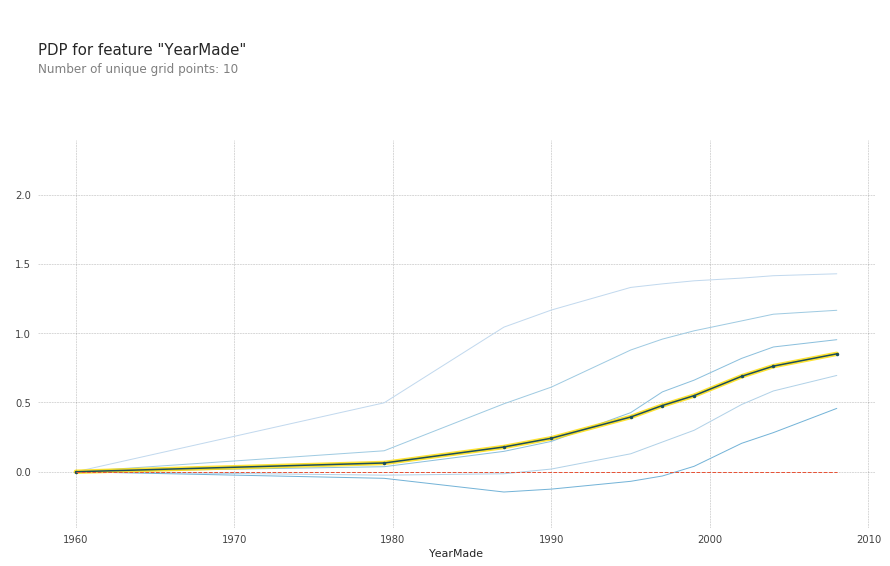

In [0]:
plot_pdp('YearMade',clusters=5);

We still get the same average but it says here are five most common shapes that we see. And this is where you could then go in and say all right, it looks like some kinds of vehicle , after 1990, their price are pretty flat. Before that, there were pretty linear. Some other kinds of vehicle were exactly the opposite, so different kinds of vehicle have these different shapes. So, this is something you could dig into. 

**Question**: So what are we going to do with this information [1:21:40](https://youtu.be/0v93qHDqq_g?t=1h21m40s)? The purpose of interpretation is to learn about a dataset and so why do you want to learn about a dataset? It's because you want to do something with it. So in this case, it's not much something if you are trying to win a Kaggle competition-- it can be a little bit like some of these insights might make you realize I could transform this variable or create this interaction, etc. **Obviously feature importance is super importance for Kaggle competitions**. But this one is much more for real life. So this is when you are talking to somebody and you say to them " okay, those plots you've been showing me which actually say that there was this kind of dip in prices based on things made between 1990 and 1997. There wasn't really. Actually they were increasing, and there was something else going on at that time". It's basically the thing that allows you to say for whatever this outcome I'm trying to drive in my business is, this is how something is driving it. So if it's like I'm looking at advertising technology, what's driving clicks that I'm actually the variable what's driving it. This is how it's related. So therefore, we should change our behavior in this way. That's really the goal of any model. That's really the goal of any model. I guess there are two possible goals: one goal of a model is just to get the predictions, like you are doing hedge fund trading, you probably want to know what the price of that equity is going to be. If you are doing insurance, you probably just want to know how much claims that guy is going to have. But probably most of the time, you are actually trying to change something about how you do business -- how you do marketing, how you do logistics, so the thing you actually care about is how the things are related to each other. 

![alt text](https://cdn-images-1.medium.com/max/800/1*Tajf1qqfWGHZVr79DIUa6g.png)

**Question** : Could you explain again why the dip did not signify what we thought it did [1:23:36](https://youtu.be/0v93qHDqq_g?t=1h23m36s)? Yes. So this is a classic boring univariate plot. So this is just taking all of the dots, all of the options, plotting YearMade against SalePrice and we are just fitting a rough average through them. It's true that products made between 1992 and 1997 on average in our dataset are being sold for less. Very often in business, you'll hear somebody look at something like this and say " we should stop auctioning equipment that is made in those years because we are getting less money for", for example. But if the truth actually is that during those years, it's just that people were making more small industrial equipment where you would expect it to be sold for less and actually our profit on it is just as high, for instance. Or it's not that things made during those years now would now be cheaper, it's that when we were selling things in those years, they were cheaper because there was a recession going on. If you are trying to actually take some action based on this, you probably don't just care about the fact that things made in those years are cheaper on average, but how does that impact today. So PDP approach where we actually say let's try and remove all of these externalities. So if something is sold on the same day to the same person of the same kind of vehicle, then actually how does YearMade impact the price. This basically says, for example, If I am deciding what to buy at an auction, then this is saying to me that getting a more recent vehicle on average really does give your more money which is not what the naive univariate plot said. 

**Comment:** Bulldozers made in 2010 probably are not close to the type of bulldozers that were made in 1960. If you are taking something that would be so very different, like a 2010 bulldozer, and then trying to just drop it to say " oh if it was made in 1960" that may cause poor prediction at a point because it's so far outside of the training set [1:26:12](https://youtu.be/0v93qHDqq_g?t=1h26m12s). Absolutely. That's a good point. It is a limitation, however, if you've got a datapoint that's in a part of the space that it has not seen before, like maybe people didn't put air conditioning in bulldozers in 1960 and you are saying how much would this bulldozer with air conditioning would have gone for in 1960, you don't really have any information to know that. This is still the best technique I know of but it's not perfect. And you kind of hope that the trees are still going to find some useful truth even though it hasn't seen that combination of features before. But yeah, it's somthing to be aware of.


TypeError: ignored

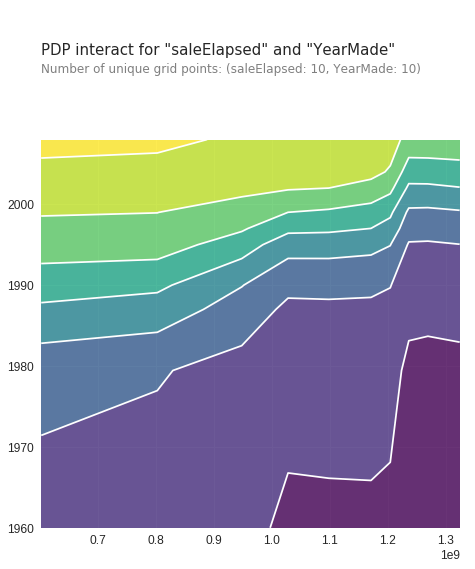

In [0]:
feats = ['saleElapsed','YearMade']
p = pdp.pdp_interact(m,x,x.columns,feats)
pdp.pdp_interact_plot(p,feats);


You can also do the same thing in a PDP interaction plot [1:27:36](https://youtu.be/0v93qHDqq_g?t=1h27m36s). And PDP interaction plot which is really what I'm trying to get to here is how does saleElapsed and YearMade together impact the price. If I do a PDP interaction plot, it shows me saleElapsed vs price, YearMade vs price, and the combination vs price. Remember, this is always log of price. That's why these prices look weird. You can see that the combination of saleElapsed and YearMade is as you would expect -- the highest prices are those where there's the least elapsed and the most recent year made. The upper right is the univariate relationship between saleElapsed and price, the lower left is the univariate relationship between YearMade and price , and the lower right is the combination of the two. It's enough to see clearly that these two things are driving price together. You can also see thse are simple diagonal lines so there is some interesting interaction going on. Based on looking at these plots, it's enough to make me think, oh, we should maybe put in some kind of interaction term and see what happens. So let's come back to that in a moment, but let's just look at a couple more. 

Remember in this case, we did one-hot-encoding -- way back at the top, we said max_n_cat = 7 [1:29:18](https://youtu.be/0v93qHDqq_g?t=1h29m18s). So we have things like Enclosure_EROPS w AC. So you have one-hot-encoded, you can pass an array of them to plot_pdp and it will treat them as a category.

![alt text](https://cdn-images-1.medium.com/max/800/1*HCdXOt7LvBPjDJ0_-fQZEw.png)

So in this case, I'm going to create a PDP plot of these three categories, and I'm going to call it " Enclosure"

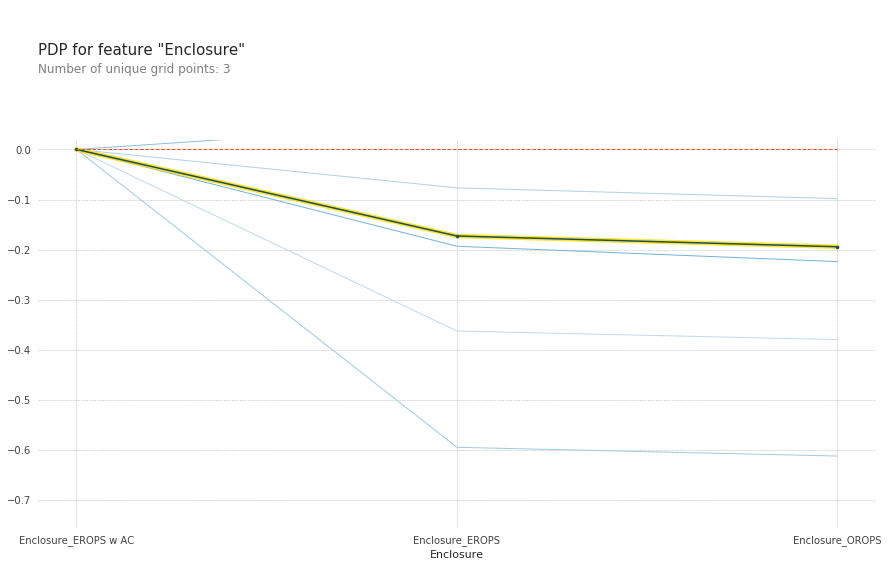

In [0]:
plot_pdp(['Enclosure_EROPS w AC','Enclosure_EROPS','Enclosure_OROPS'],5,'Enclosure');

I can see here that **Enclosure_EROPS w AC** on average are more expensive than **Enclosure_EROPS or Enclosure_OROPS.** It actually looks like the latter two are pretty similar or else Enclosure_EROPS w AC is higher. So at this point, I'm probably being inclined to hop on to Google and type " erops orops" and find out what these things are and here we go.

![alt text](https://cdn-images-1.medium.com/max/800/1*9Zw3mj2xNERdmcb0iFpTbA.png)

So it turns out that EROPS is enclosed rollover protective structure and so it turns out that if you bulldozer is fully enclosed then optionally you can also get air conditioning. So actually this thing is telling us whether it has air conditioning. If it's an open structure, then obviously you don't have air conditioning at all. So that's what these three levels are. So we've now learnt all other things being equal, the same bulldozer, sold at the same time, built at the same time, sold to the same person is going to to be quite a bit more expensive if it has air conditioning than if it doesn't. So again, we are getting this nice interpretation ability. Now that I spent some time with this dataset, I'd certainly noticed that knowing this is the most important thing, you do notice that there is a lot more air conditioned bulldozers nowadays than they used to be and so there is definitely an interaction between data and that. 





In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade


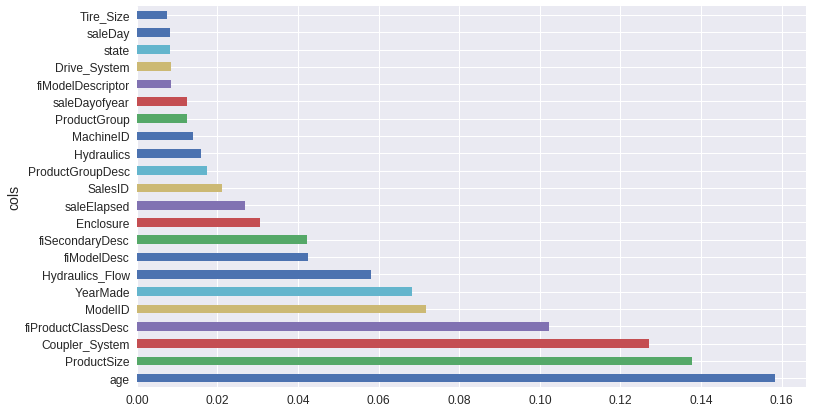

In [0]:
X_train,X_valid = split_vals(df_keep,n_trn)
m= RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.6,
                       n_jobs=-1)
m.fit(X_train,y_train)
plot_fi(rf_feat_importance(m,df_keep));

Based on the earlier interaction analysis, I've tried, first of all, setting everything before 1950 to 1950 because it seems to be some kind of missing values [1:31:25](https://youtu.be/0v93qHDqq_g?t=1h31m25s). I've set age to be equal to saleYear-YearMade. Then I tried running a random forest on that. Indeed, age is now the single biggest thing, saleElapsed is way back down here, YearMade is back down here. So we've used this to find an interaction. But rememeber, of course a random forest can create an interaction. But rememeber, of course a random forest can create an interaction through having multiple split points, so we shouldn't assume that this is actually going to be a better result. **And in practice, I actually found when I looked at my score and my RMSE, adding yes was actullay a little worse**. We will see about that later probably in the next lesson.

# Tree interpreter (introduction) [1:32:34](https://youtu.be/0v93qHDqq_g?t=1h32m34s)

One last thing is tree interpreter. This is also in the category of things that most people don't know exists, but it's super important. Almost pointless for Kaggle competitions but super important for real life. Here is the idea. Let's say you are an insurance company and somebody rings up and you give them a quote and they say "oh, that's $500 more than last year. Why?" So in general, you've made a prediction from some model and somebody asks why. This is where we use this method called tree interpreter. What tree interpreter does it is allows us to take a particular row.



In [0]:
!pip install treeinterpreter

In [0]:
from treeinterpreter import treeinterpreter as ti
df_train, df_valid = split_vals(df_raw[df_keep.columns],n_trn)

So in this case, we are going to pick row number zero.

In [0]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665,          0, 1284595200,          1,
                 0,       3232,    4364751,          0,    2300944,          4,          0,          0,
                12,         16,         35,        259,          4,         11]])

What I can do with a tree interpreter is I can go **ti.predict**, pass in my random forest and my row(so this would be like this particular customer's insurance information, or in this case this particular auction). And it will give me back three things :
- **prediction** : The prediction from the random forest
- **bias** : the average sale price across the whole original dataset
- **contributions** : A column and the value to split by (i.e the predictor), and how much it changed the predicted value.


In [0]:
prediction, bias, contributions = ti.predict(m,row)

So you can think of it this way[1:34:51](https://youtu.be/0v93qHDqq_g?t=1h34m51s). The whole dataset had an average log sale price of 10.2. The dataset for those with Coupler_system <-0.5 had an average of 10.3. The dataset for Coupler_system <= 0.5 and Enclosure <= 2.0 was 9.9 and then eventually we get all the way up here and also with ModelID <= 4573 , it is 10.2. So you could ask, why did we predict 10.2 for this particular row?

![alt text](https://cdn-images-1.medium.com/max/800/1*O-07xrFQS6Oyz0EqAIUOoQ.png)

That is because we started with 10.19:
- Because the coupler_system was less than 0.3, we added about 0.2 to that (so we went from 10.19 to 10.34)
- Because enclosure was less than 2, we subtracted about 0.4
- Then because ModelID was less than 4573, we added about 0.7

So you can see with a single tree, you could break down why it is that we predicted 10.2. At each of these decision points, we are adding or subtracting a little bit from the value. What we could then do is we could do that for all the trees and we could take the average. So everytime we see enclosure did we increase or decrease the value and by how much? Everytime we see ModelID, did we increase or decrease the value and by how much? We could take the average of all of those that's what ends up this thing called **contributions.**




In [0]:
prediction[0], bias[0]

(array([9.30097]), 10.105540546387903)

In [0]:
idxs = np.argsort(contributions[0])

So here is all of our predictiors and the value of each [1:37:54](https://youtu.be/0v93qHDqq_g?t=1h37m54s)

In [0]:
[o for o in zip(df_keep.columns[idxs],df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54901590270616),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1599451217630373),
 ('age', 11, -0.13348576108473184),
 ('fiSecondaryDesc', nan, -0.08258321627453227),
 ('fiModelDesc', 'KX1212', -0.07874491401437096),
 ('saleElapsed', 1284595200, -0.023620459207202904),
 ('saleDayofyear', 259, -0.018581275330202596),
 ('Enclosure', 'EROPS', -0.018137745299581898),
 ('saleDay', 16, -0.007294596686559141),
 ('Tire_Size', nan, -0.006537156610200823),
 ('fiModelDescriptor', nan, -0.003950974093081205),
 ('state', 'Ohio', -0.0030946918464018315),
 ('SalesID', 4364751, -0.001529264723157553),
 ('MachineID', 2300944, -0.0013175427466401324),
 ('Drive_System', nan, 0.001578094681860609),
 ('ProductGroup', 'TEX', 0.009926258168997792),
 ('ProductGroupDesc', 'Track Excavators', 0.018182368305357154),
 ('Hydraulics', 'Standard', 0.018564834037402233),
 ('Hydraulics_Flow', nan, 0.026546915488444435),
 ('ModelID', 665, 0.05315424205

In [0]:
contributions[0].sum()

-0.8045660550323378

So then there is this thing called bias and the bias is just the average before we start doing any splits [1:39:03](https://youtu.be/0v93qHDqq_g?t=1h39m3s). If you start with the average log of value and then we went down each tree and each time we saw YearMade, we had some impact: Coupler_system, product size, and so forth.

We might come back to tree interpreter next time, but the basic idea ( this is the last of our key interpreter points) is that we some ability to not only tell us about the model as a whole and how it works on average , but to look at how the model makes prediction for an individual row. And that's what we are doing here.

# LESSON 5           
[Video](https://youtu.be/3jl2h9hSRvc)

# Test sets, training sets, validation sets and OOB

We have a dataset with bunch of rows in it and we've got some dependent variable. What is the difference between machine learning and any other kind of work? The difference is that **in machine learning, the thing we care about is the generalization accuracy  or the generalization error** where else, in pretty much in everything else, all we care about is how well we could map to the observations. So this thing about generalization is the key unique piece of machine learning. And if we want to know whether we are doing a good job of machine learning, we need to know whether we are doing a good job of generalizing. If we don't know that, we know nothing. 

**Question:** By generalizing, do you mean scaling? Being able to scale larger? [1:26](https://youtu.be/3jl2h9hSRvc?t=1m26s) 
- No, I don't mean scaling at all. Scaling is an important thing in many areas. It's like okay we've got something that works on my computer with 10,000 items, I now need to make it work on 10,000 items per second. So scaling is important but not just for machine learning but for about everything we put in production. 

Generalization is where a model that can predict cats from dogs. I've looked at 5 pictures of cats and 5 pictures of dogs and I've build a model that is perfect. Then I look at a different set of 5 cats and dogs, and it gets them all wrong. So in that case, what it learned was not the difference between a cat or a dog, but it learned about those 5 exact cats looked like and what those 5 exact dogs looked like. Or I build a model of predicting grocery sales for a particular product, so for toilet rolls in New Jersey last month, and then I go and put it into production and it scales great but it fails to predict anything other than toilet rolls in New Jersey. It also turns out it only did well for last month, not the next month. **So these are all generalization failures. **

**The most common way that people check for the ability to generalize is to create a random sample. So they will grab a few rows at random and pull it out into a test set**. Then they will build all of their models on the rest of the rows and then when they are finished , they will check that the accuracy they got on the test set ( the rest of the rows are called the training set). So at the end of their modeling process, on the traning set, they got an accuracy of 99% of predicting cats from dogs, at the very end, they check it against a test set to make sure that the model really does generalize.

**Now the problem is what if it doesn't? Well, I could go back and change some hyperparameters**, do some data augmentation, whatever else trying to create a more generalizable model. And then I'll go back again after doing all that, and check and it's still no good. I'll keep doing this again and again until eventually **after 50 attempts, it does generalize. But does it really generalize?** Because maybe all I've done is accidentally found this one which happens to work just for that test set because I've tried 50 different things. So if I've got something which is right coincidentally 5% of the time, they are not very likely to accidentally get a good result. So what we generally do is we put aside a second dataset ( validation set). Then everything that's not in the validation or test is now training. What we do is we train a model, check it against the validation to see if it generalizes, do that a few times. Then when we finally got something we think will generalize successfully based on the validation set (at the end of the project), we check it against the test set. 

**Question:** So basically by making this two layers: test set and validation set, if it gets one right and the other is wrong, you are kind of double checking your errors? [5:19](https://youtu.be/3jl2h9hSRvc?t=5m19s) 
- It's checking that we haven't overfit to the validation set. So if we are using the validation set again and again, then we could end up not to coming up with a generalizable sort of hyper parameters but a set of hyper parameters that just so happened to work on the training set and the validation set. So if we try 50 different models against the validation set and then at the end of all that, we then check that against the test set and it's still generalized as well, then we are going to say okay that's good we've actually come up with generalizable model. If it doesn't, then that's going to say we've actually now overfit to the validation set. At that point, you are in trouble. Because you don't have anything left behind. So the idea is to use effective techniques during the modeling so that doesn't happen. But if it's going to happen, you want to find out about it- You need that test set to be there because otherwise when you put it in production and then turns out that it doesn't generalize, that would be really bad outcome. You'll end up with less people clicking on your ads or selling less of your products, or providing car insurance to very risky vehicles.

**Question:** So just to make sure, do we need to ever check if the validation set and the test set are coherent or you just keep test set? [6:43](https://youtu.be/3jl2h9hSRvc?t=6m43s)
- So if you've done what I've just done here which is to randomly sample, there is no particular reason to check as long as they are big enough. But we will come back to your question in a different context in just moment.

**Another trick we've learnt for random forest is a way of not needing a validation set** [7:10](https://youtu.be/3jl2h9hSRvc?t=7m10s). And the way we learnt was to use, instead, the OOB score. This idea was to say every time we train a tree in a random forest, there is a bunch of observations that are held out anyway because that's how we get some of the randomness. So let's calculate our score for each tree based on those held out samples and therefore the forest by averaging thre trees that each row was not part of training. **So the OOb score gives us something which is pretty much similar to the validation score, but on average it's a little less good. Why? Because every row is going to be using a subset of the trees to make its prediction, and with less trees, we know we get a less accurate prediction.** So that's a subtle one  and if you didn't get it, have a think during the week until you understand why this is because it's really interesting test of your understanding of random forests. Why is OOB score on average less good than your validation score? They are both using random held-out subsets.

Anyway, it's generally close enough [11:06](https://youtu.be/3jl2h9hSRvc?t=11m6s). So why have a validation set at all when you are using random forests? If it's a randomly choosen validation set, it's not strictly speaking neccesary but you've got like four levels of things to test -- so you could test on the OOB, when that's working well, you can test on the validation set, and hopefully by the time you check against the test set, there's going to be no surprises so that'll be one good reason. 

What Kaggle do, the way they do this, is kind of clever. What Kaggle do is they split the test set into two pieces: a public and a private. An they don't tell you which is which. So you submits your predictions to Kaggle and then a random 30% of those are used to tell you the leaderboard score. But then at the end of the competition, that gets thrown away and they use the other 70% to calculate your real score. So what that's doing is that you are making sure that you are not continuously using the feedback from the leaderboard to figure out some set of hyperparameters that happens to do well on the public but actually doesn't generalize. So it's a great test. This is one of the reasons why it's good practice to use Kaggle because at the end of a competition, at some point this will happen to you, and you'll drop a hundred places on the leaderboad on the last day of the competition when they use the private test set and say oh okay, that's overfit. It's much better to practice and get that sense there than it is to do it in a company where there's hundreds of millions of dollars on the line. 

This is like the easiest possible situation where you are able to use a random sample for your validation set [12:55](https://youtu.be/3jl2h9hSRvc?t=12m55s). Why might I not be able to use a random sample from my validation or possibly fail? My claim is that by using a random validation set, we could get totally the wrong idea about our model. **The important thing to remember is when you build a model , you always have a systematic error which is that you're going to use the model at a later time than the time you built it. You're going to put it into production by which time the world is different to the world that you are in now and even when you're building the model, you're using data which is older than today anyway.** So there's some lag between the data that you are building it on and the data that it's going to actually be used in real life. And a lot of the time, if not most of the time, that matters. 

So if we are predicting who is going to buy toilet paper in New Jersey and it takes us 2 weeks to put it in production and we did it using data from last couple of years and by that time, things may look very different. And particularlly our validation set, if we randomly sampled it, and it was from a 4 year period, then the vast majority of the data is going to be over a year old. And it maybe that the toilet paper building a habits of folks in New Jersey may have dramatically shifted. Maybe they've got a terrible recession there now and they can't afford a high quality tolet paper anymore. Or maybe they know their paper making industry has gone through the roof and suddenly they are buying a lot toilet paper because it's so cheap. So the world changes and **therefore if you use a random sample for your validation set, then you are actually checking how good are you at predicting things that re totally obsolete now?** How good are you at predicting things that happend 4 years ago? **That's not interesting. So what we want to do in practice, anytime there is some temporal piece is to instead say assuming that we've ordered it by time, we'll use the latest portion as our validation set.** I suppose, actually do it properly:

![alt text](https://cdn-images-1.medium.com/max/1600/1*Ka6WNHrQDnoD1WfvYxKl_w.png)

That's our validation set, and that's our test set. So the rest is our training set and we use that and we try and be able to model that still works on stuff that's later in time than anything the model was built on. So we are not just testing generalization in some kind of abstract sense but in a very specific time sense which is it generalizes to the future. 

**Question:** As you said, there is some temporal ordering in the data, so in that case, it is wise to take the entire data for training or only a few recent dataset for training [19:07]? 
- Yeah, that is a whole other question. So how do you get the validation set to be good? So I build a random forest on all the training data. It looks good on the training data, it looks good on OOB. And this is actually a really good reason to have OOB. If it looks good on OOB then it means you are not overfitting in a statistical sense. It's working well on a random sample. But then it looks bad on the validation set. So what happened? Well, what happened was that you somehow failed to predict the future. You only predicted the past so Suraj had an idea about how we could fix that. Okay, well, **maybe we should just train so maybe we shouldn't use the whole training set. We should try to a recent period only. Now on the downside, we are using less data so we create less rich models, on the upside, it's more up to data data**. And this is something you have to play around with. **Most machine learning functions have ability to provide a weight that is given to each row. So for example, with a random forest, rather than boostrapping at random, you could have a weight on every row and randomly pick that row with some probability. So we could put probability such that most recent rows have a higher probability of being selected**. That can work really well. It's something that you have to try and if you don't have a validation set that represents the future compared to what you are training on, you have no way to know which of your techniques are working.

**How do you make the compromise between amount of data vs recency of data?** What I tend to do is when I have this kind of temporal issue, which probably most of the time, once I have somthing that's working well on the validation set, I wouldn't then go and just use that model on the test set because the set is much farther in the future compared to the training set. So I would replicate building that model again but this time I would combine the training and validation sets together and retrain the model. At that point, you've got no way to test against a validation set, you have to make sure you have a reproducible script or notebook that does exactly the same steps in exactly the same ways because if you get something wrong then you're got a problem. **So what I do in practice is I need to know if my validation set is a truly representative of the test set**. So what I do is I build 5 models on the training set, and I try to have them vary in how good I think they are. Then I score my 5 models on the validation set and then I also score them on the test set. So I'm cheating since I'm using any feedback from the test set to change my hyperparameters -- I'm only using it for this one thing which is to check my validation set. So I get my 5 scores from the validation set and test set and then I check that they fall in a line. If they don't then you're not going to get good enough feedback from the validation set. So keep doing that process until you're getting a line that can be quite tricky. Trying to create something that's as similar to the real world outcome as possible is difficult. An in the real world, the same is true of creating the test set - the test set has to be as close to production as possible. So what's the actual mix of customers that are going to be using this, how much time is there actually going to be between when you build the model and when you put it in production? How often you are going to be able to refresh to model? These are all the things to think about when you build that on test set.

**Question:** For five models, you start with maybe just random dât, average, etc [24:45](https://youtu.be/3jl2h9hSRvc?t=24m45s)? 
- Maybe five not terrible ones but you want some variety and you also particular want some variety in how well they might generalize through time. So one that was trained on the whole training set, one was trained on the last two weeks, one that was trained on the last six week, one which used lots and lots of columns and might overfit a bit more. So you want to get a sense of if my validation set fails to generalize temporarily, I'd want to see that, if it fails to generalize statistically, I'd want to see that. 

**Question:** Can you explain a bit more in detail what you mean by changing your validation set so it indicates the test set? What does that look like [25:28](https://youtu.be/3jl2h9hSRvc?t=25m28s)?
- Let's take the groceries competitions where we are trying to predict the next weeks of grocery sales. The possible validation set that Terrance and I played with was:
    - Random sample (4 years)
    - Last month of data (July15-Aug15)
    - Last 2 weeks (Aug 1-15)
    - Same day range one month earlier (Jul 15-30)
- The test set in this competition was the 15th to the 30th of the August. So above were 4 different validation sets we tried. With random, our results were all over the place. With last month, they were not bad but not great. The last two weeks, there was a couple that didn't look good but on the whole they were good. The same day range a month earlier, they've got a basically perfect line. 

**Question**: What exactly are we comparing it to from the test set [26:58]? 
- I build 5 models, so there might be 1.just predict the average, 2.do some kind of simple group mean of the whole dataset, 3.do some group mean over the last month of the data, 4.build a random forests of the whole thing, 5. build random forest from the last 3 weeks. On each of those, I calculate the validation score. The I retrain the model on the whole training set and calcualate the same thing on the test set. So each of these points now tells me how well did it go on the validation set and how well did it go in the test set. If the validation set is useful, we would say everytime the validation score set improves, the test set score should also improve.

**Question**: When you "retrain" do you mean retrain the model on training and validation set[27:50]? Yes, so once I've got the validation score based on just training set , then retrain it on the train and validation set and check against the test set. 

**Question**: By test set, do you mean submitting it to Kaggle and check score? If it's Kaggle, then your test set is Kaggle's leader board. In the real world, the test set is this third dataset you put aside. It's that third dataset that having it reflect real world. Production differences is the most important step in a machine learning project. Why it is the most important step? Because if you screw up everything else but you don't screw up that, you'll know you screwed up. If you've got a good test set, then you'll know you screwed up because you screwed up something else and you tested it and it didn't work out, it's okay. You're not going to destroy the company. If you screwed up creating the test set, that would be awful. Because then you don't know if you've made a mistake. You try to build a model, you test it on the test set and it looks good. But the test set was not indicative of real world enviroment. So you don't actually know if you are going to destroy the company. Hopefully you've got ways to put this thing into production gradually so you won't actually destroy the company but you'll at least destroy your reputation at work. Oh Jeremy tried to put this thing into production and in the first week the cohort we tried it on, their sales halved and we're never gonna give Jeremy a machine learning job again. But if Jeremy had used a proper test set and he would have known, uh-oh this half as good as my validation set said it would be, I'll keep trying. Now I'm not going to get in any trouble. I was actually like oh, Jeremy is awesome -- he identifies ahead of time when there's going to be a generalization problem. 

This is something everybody talks about a little bit in machine learning classes but often it stops at the point where you learned that **there is a thing in sklearn called make train_test_split and it returns these things and off you go or here is the cross-validation function** [30:10](https://youtu.be/3jl2h9hSRvc?t=30m10s). The fact that these things always give you random samples tells you that much if not most the time, **you shouldn't be using them**. The fact that random forest gives you an OOB for free, it's useful but only tells that **this generalizes in a statistical sense, not in a practical sense.**

**Cross validation [30:54](https://youtu.be/3jl2h9hSRvc?t=30m54s)**

Outside of class, you guys have been talking about  alot which makes me fell somebody's been over emphasizing the value of this technique. So I'll explain what cross-validation is and then I explain why you probably shouldn't be using it most of the time. 

Cross validation says let's not just pull out one validation set, but let's pull out 5 , for example. So let's assume that we're going to randomly shuffle the data first of all. This is critical. 
1. Randomly shuffle the data.
2. Split it into 5 groups
3. For model No1, we will call the first one validation set, and the bottom for the training set. 
4. We will train and we will  check against the validation and we get some RMSE, $R^2$ , etc.
5. We will repeat the 5 times, and we will take the average of RMSE , $R^2$, etc and that is a cross validaiton average accuracy.

What is the benefit os using cross-validation over a standard valdiation set I talked about before? You can use all of the data. You don't have to put anything aside. And you get a little benefit as well in that you've now got five models that you could ensemble together, each one used 80% of data. So sometimes that ensemble can be helpful.

What could be some reasons that you wouldn’t use cross-validation? For large dataset, it will take a long time. We have to fit five models rather than one, so time is a key downside. If we are doing deep learning and it takes a day to run, suddenly it takes five days or we need 5 GPUs. What about my earlier issues about validation sets? Our earlier concerns about why random validation sets are a problem are entirely relevant here. These validation sets are random, so if a random validation set is not appropriate for your problem, most likely because, for example, of temporal issues then none of these five validation sets are any good. They are all random. So if you have temporal data like we did before, there’s no way to do cross validation or no good way to do cross validation. You want to have your validation set to be as close to the test set as possible, and you can’t do that by randomly sampling different things. You may well not need to do cross validation because most of the time in the real world, we don’t really have that little data — unless your data is based on some very very expensive labeling process or some experiments that cost a lot to run, etc. But nowadays, data scientists are not very often doing that kind of work. Some are, in which case this is an issue, but most of us aren’t. So we probably don’t need to. If we do do it, it’s going to take a whole a lot of time, then even if we did do it and we took up all that time, it might give us totally the wrong answer because random validation sets are inappropriate for our probblem.

I’m not going to be spending much time on cross validation because I think it’s an interesting tool to have, it’s easy to use (sklearn has a cross validation thing you can use), but it’s not that often that it’s going to be an important part of your toolbox in my opinion. It’ll come up sometimes. So that is validation sets.

#Tree interpretation [38:02](https://youtu.be/3jl2h9hSRvc?t=38m2s)

What does three interpreter do and how does it do it? Let's start with output of tree interpreter [38:51](https://youtu.be/3jl2h9hSRvc?t=38m51s)

![alt text](https://cdn-images-1.medium.com/max/600/1*J2PsfxvM-FatWtVTPn10ww.png)

The root of the tree is before there's been any split at all. So 10.189 is the average log price of the options in our training set. Then if I go **Coupler_System <= 0.5**, then we get an average of 10.345 ( the subset of 16815). Off the people with **Coupler_System <=0.5**, we then take the subset where **Enclosure <= 2.0** and average log price there is 9.955. Then the final step is **ModelID <= 4573.0 and that gives us 10.226

![alt text](https://cdn-images-1.medium.com/max/800/1*9Y5L0q2vSzI6ZE8S5IS9YA.png =400x300)

We can then calculate the change in average log price by each additional criteria. We can draw that as what's called a **waterfall plot**. Waterfall plots are one of the most useful plots I know about and weirdly enough, there's nothing in Python to do them. This is one of these things where there's this disconnect between the world of management consulting and business where everybody uses waterfall plots all the time and academia who have no idea what these things are. Everytime you have a starting point and a number of changes and a finishing point, waterfall charts are pretty much always the best way to show it. 

![alt text](https://cdn-images-1.medium.com/max/800/1*Ft7pCDIdupo2GkqIxkOAiw.png =400x300)

With Excel 2016 build-in. You just click insert waterfall chart and there it is. If you want to be a hero, create a waterfall chart package for matplotlib, put it on pip, and everybody will love you for it. These are actually super easy to build. You basically do a stacked column plot where the bottom of this is all white. You can kind of do it but if you can wrap that up, put the points in the right spots and color them nicely, that would be totally awesome. I think you've got the skills to do it, and would be a terrific thing for your portfolio. 

In general, they are going from all, then going through each change, then the sum of all of those is going to be equal to the final decision [43:38](https://youtu.be/3jl2h9hSRvc?t=43m38s). So if we were just doing a decision tree and someone asks "how come this particular auction's prediction was this particular price?", this is how you can answer "because these three things had these three impacts".

For a random forest, we could do that across all of the trees. So everytime we see Coupler, we add up that change. Everytime we see Enclosure, we add up that change and so on. Then we combine them all together, we get what tree interpreter does. So you could go into the source code for tree interpreter and it's not at all complex logic. Or you could build it yourself and you can see how it does exactly this.




In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns],n_trn)

In [0]:
row = X_valid.values[None,0];row

array([[      1999,          0,          5,         17,        665,          0, 1284595200,          1,
                 0,       3232,    4364751,          0,    2300944,          4,          0,          0,
                12,         16,         35,        259,          4,         11]])

In [0]:
prediction,bias,contributions = ti.predict(m,row)

So when you go treeinterpreter.predict with a random forest model for some specific auction (in this case it's zero index row), it tells you:
- prediction : the same as the random forest prediction
- bias : this is going to be always the same - it's the average saleprice for everybody for each of the random samples in the tree.
- contributions : the total of all the contributions for each time we see that specific column appear in a tree.


In [0]:
prediction[0],bias[0]

(array([9.30097]), 10.105540546387903)

The last time I made a mistake of not sorting this correctly. So this time np.argsort is a super handy function. It doesn't actually sort contributions[0] , it just tells you where each item would move to if it were sorted. So now by passing **idxs** to each one of the column, the level, and contribution, I can the print our all those in the right order. 


In [0]:
idxs = np.argsort(contributions[0])
[o for o in zip(df_keep.columns[idxs],df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.54901590270616),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1599451217630373),
 ('age', 11, -0.13348576108473184),
 ('fiSecondaryDesc', nan, -0.08258321627453227),
 ('fiModelDesc', 'KX1212', -0.07874491401437096),
 ('saleElapsed', 1284595200, -0.023620459207202904),
 ('saleDayofyear', 259, -0.018581275330202596),
 ('Enclosure', 'EROPS', -0.018137745299581898),
 ('saleDay', 16, -0.007294596686559141),
 ('Tire_Size', nan, -0.006537156610200823),
 ('fiModelDescriptor', nan, -0.003950974093081205),
 ('state', 'Ohio', -0.0030946918464018315),
 ('SalesID', 4364751, -0.001529264723157553),
 ('MachineID', 2300944, -0.0013175427466401324),
 ('Drive_System', nan, 0.001578094681860609),
 ('ProductGroup', 'TEX', 0.009926258168997792),
 ('ProductGroupDesc', 'Track Excavators', 0.018182368305357154),
 ('Hydraulics', 'Standard', 0.018564834037402233),
 ('Hydraulics_Flow', nan, 0.026546915488444435),
 ('ModelID', 665, 0.05315424205

So the small piece of industrial equipment meant that it was less expensive. If it was made pretty recently meant that was more expensive, etc. **So this is not going to really help you much at all with Kaggle where you just need predictions. But it's going to help you a lot in a production environment  or even pre production**. So something which any good manager should do if you say here is a machine learning model I think we should use is they should go away and grab a few example of actual customers or actual auctions and check whether your model looks intuitive. If it says my prediction is that lots of people are going to really enjoy this crappy movie, and it is like "wow, that was a really crappy movie" then they're going to come back to you and say "explain why your model is telling me that I'm going to like this movie because I hate that movie". Then you can go back and say well, it's because you like this movie and because you're this age range and you're this gender, and on average actually people like you did like that movie. 

**Question**: What the second element of each tuple [47:25](https://youtu.be/3jl2h9hSRvc?t=47m25s)? 
- This is say for this particular row, "ProductSize" was "Mini", and it was 11 years old, etc. So it's just feeding back and telling you. Because this is actually what it was: 



```
array([[      1999,          0,         17,          5,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,          0,    2300944,          4,          4,          0,
                 0,         16,         35,        259,         11]])
```

It was these numbers. So I just went back to the original data to actually pull out the descriptive versions of each one. 

So if we sum up all the contributions together, and then add them to the bias, then that would give us the final prediction.


In [0]:
contributions[0].sum()

-0.8045660550323378

This is an almost totally unknown technique and this particular library is almost unknown as well. So it's a great opportunity to show something that a lot of people don't know. It 's totally critical in my opinion but rarely done. 

So this is kind of the end of the random forest interpretation piece and hopefully you've now seen enough that when somebody says we can't use modern machine learning techniques because they are black boxes that aren't interpretable, you have enough information to say you are full of crap. They are extremely interpretable and the stuff that we've just done -- trying to do that with a linear model, trying to do it so that is not giving you totally the wrong answer and you had no idea it's a wrong answer is going to be a real challenge. 

# Extrapolation [49:23](https://youtu.be/3jl2h9hSRvc?t=49m23s)

The last step we are going to do before we try and build our own random forest is to deal with this tricky issue of extrapolation. So in this case, if we look at the accuracy of our recent trees, we still have a big difference between our validation score and our training score. 

![alt text](https://cdn-images-1.medium.com/max/800/1*Tu28k2nmQq7SNqHPurMqMw.png)

Actually, in this case, the difference between the OOB (0.89420) and the validation (0.89319) is actually pretty close. So if there was a big difference, I'd be very worried about whether we've dealt with temporal side of things correctly. Here is the most recent model:

![alt text](https://cdn-images-1.medium.com/max/800/1*gtNHvpXOlgTmgPv4Chi1Zg.png)

On Kaggle, we need the last decimal place. In real world , I probably stopped here. But quite often you'll see there's a big difference between your validation score and your OOB score, and I want to show you how you would deal with that particularly because we know that OOB score should be a little worse because it's using less trees so it gives me a sense that we should get to do a little bit better. The way we should be able to do a little bit better is by handling the time component a little bit better . 

Here is the problem with random forests when it comes to extrapolation. When you've got a dataset that got 4 years of sales data in it, and you create your tree and it says if it's in some particular store and some particular item and it is on special, here is the average price. And it actually tells us the average price over the whole training set which could be pretty old. **So when you then want to step forward to what is going to be the price next month, it's never seen next month. Where else with a linear model, it can find a relationship between time and price where even though we only had this much data, when you then go and predict something in the future , it can extrapolate that. But a random forest can't do that. If you think about it, there is no way for a tree to be able to say well next month, it would be higher still. So there is a few ways to deal with this, and we'll talk about it over the next couple of lessons, but one simple way is just to try to avoid using time variables as predictors** if there's something else we could use that's going to give us better or stronger relationship that's actually going to work in the future [52:19](https://youtu.be/3jl2h9hSRvc?t=52m19s)

So in this case, what I wanted to do was to first of all figure out what's the difference between our validation set and training set. If I understand the difference , then that tells me what are the predictors which have a strong temporal component and therefore they maybe irrelevant by the time I get to the future time period. So I do something really interesting which is I create a random forest where my dependent variable is " is it in the validation set" (is_valid). I've gone back and I've got my whole dataframe with the training and validation all together and I've created a new column called **is_valid** which I've set to one and then for all of the stuff in the training set, I set it to zero. So I've got a new column which is just is this in the validation set or not and then I'm going to use that as my dependent variable and build a random forest. This is a random forest not to predict price but predict is this in the validation set or not. So if your variable were not time dependent, the it shouldn't be possible to figure out if something is in the validation or not. 



In [0]:
df_ext = df_keep.copy()
df_ext['is_valid']=1
df_ext.is_valid[:n_trn]=0
x,y,nas = proc_df(df_ext,'is_valid')

This is a great trick in Kaggle because they often won't tell you whether the test set is a random sample or not . So you could put the test set and training set together , create a new column call **is_test** and see if you can predict it. If you can, you don't have a random sample which means you have to figure out how to create a validation set from it. 

In [0]:
m = RandomForestClassifier(n_estimators=40,min_samples_leaf=3,max_features =0.5, n_jobs=-1, oob_score=True)
m.fit(x,y)
m.oob_score_

0.9999925210345902

In this case, I can see I don't have a random sample because my validation set can be predicted with a 0.9999 $R^2$.

So then If I look at feature importance, the top thing is sales ID[54:36]. So this is really interesting. It tells us very clearly SalesID is not a random identifier but probably it's somthing that's just set consecutively as time goes on-- we just increase the SaleID. saleElapsed was the number of days since the first date in our dataset so not surprisingly that also is a good predictor. Interestingly MachineID - clearly each machine is being labeled with some consecutive identifier as well and then there's a big drop in importance, so we 'll stop here. 

In [0]:
fi = rf_feat_importance(m,x); fi[:10]

,cols,imp
10,SalesID,0.843569
6,saleElapsed,0.122558
12,MachineID,0.023804
0,YearMade,0.004143
7,Enclosure,0.001475
4,ModelID,0.001325
9,fiModelDesc,0.001172
19,saleDayofyear,0.000760
1,Coupler_System,0.000430
21,age,0.000335


Let's next grab those top three and we can then have a look at their values both from the training set and in the validation set. [55:22](https://youtu.be/3jl2h9hSRvc?t=55m22s)


In [0]:
feats = ['SalesID','saleElapsed','MachineID']
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [0]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


We can see for our example, SalesID on average is 1.8 million in the training set and 5.8 million in the validation set (notice that the value is divided by 1000). So you can confirm they are very different. 

So let's drop them. 

In [0]:
x.drop(feats,axis=1,inplace=True)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3,max_features=0.5,n_jobs=-1, oob_score=True)
m.fit(x,y);
m.oob_score_

0.9788644437519477

So after I drop them , let's now see if I can predict whether something is in the validation set. I still can with 0.98 $R^2$.

In [0]:
fi = rf_feat_importance(m,x); fi[:10]

,cols,imp
18,age,0.223826
0,YearMade,0.193544
16,saleDayofyear,0.165642
4,ModelID,0.077804
8,fiModelDesc,0.063171
14,saleDay,0.058469
15,state,0.054471
3,fiProductClassDesc,0.033613
5,fiSecondaryDesc,0.023460
6,Enclosure,0.020859


Once you remove some things, then other things can come to the front, and it now turns out that not surprising age -- things that are old are more likely to be in the validation set because earlier on in the training set, they can't be that old yet. **YearMade** for same reason. So then we can try removing those as well -- **SalesID, saleElapsed, MachineID** from the first one, **age, YearMade, and saleDayofyear** from the second one. They are all time dependent features. I still want them in my random forest if they are important. But if they are not important, then taking them out if there are some other non time dependent variables that work just as well -- that would be better. Because now I am going to have a model that generalizes over time better. 

In [0]:
set_rf_samples(50000)

feats = ['SalesID','saleElapsed','MachineID','age','YearMade','saleDayofyear']

X_train,X_valid = split_vals(df_keep,n_trn)
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf=3,
                         max_features = 0.5, n_jobs=-1, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20792857324786873, 0.24797676046594697, 0.9096427149631545, 0.8901829082452388, 0.8930532192243713]


So here, I'm just going to go through each one of those features and drop each one, one at a time, retrain a new random forest, print out the score [57:19](https://youtu.be/3jl2h9hSRvc?t=57m19s). Before we do any of that, our score was 0.8914 for validation, 0.8933 for OOB. And you can see below, **When I remove SalesID, my score goes up**. This is what we were hoping for. We've removed a time dependent variable, there were other variables that could find similar relationships without the time dependency. So removing it caused our validation to go up. Now OOB didn't go up, because this is genuinely statistically a useful predictor, but it's a time dependent one and we have a time dependent validation set. So this is really subtle but it can be really important. It's trying to find the things that give you a generalizable a cross time prediction and here is how you can see it. 

In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train,X_valid = split_vals(df_subs,n_trn)
    m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,
                             max_features=0.5,n_jobs=-1,oob_score=True)
    m.fit(X_train,y_train)
    print(f)
    print_score(m)

SalesID
[0.20928868871999678, 0.24672422634369273, 0.9084567472232292, 0.8912894818753392, 0.8922701814731231]
saleElapsed
[0.21467693594058043, 0.2551064448512242, 0.9036824111672556, 0.8837773335723049, 0.8865187338199796]
MachineID
[0.20687532004989176, 0.24480926695996716, 0.9105557983404272, 0.8929704545633443, 0.8949614074932838]
age
[0.20949229370128203, 0.2491471841788784, 0.9082785462069575, 0.8891438120177796, 0.891717382718707]
YearMade
[0.2089928597579353, 0.25094157046827503, 0.9087153565733802, 0.8875412641709115, 0.892204981866386]
saleDayofyear
[0.20877457990349424, 0.2448374316746146, 0.9089059390955553, 0.8929458261655187, 0.8928951925254608]


We should remove SalesID for sure, but saleElapsed didn't get better, so we don't want. MachineID did get better - 0.8913 to 0.8915 so it 's actually quite a bit better. age got a bit better. YearMade got worse, saleDayYear got a bit better. 

In [0]:
reset_rf_samples()

So  now we can say, let's get rid of three where we know that getting rid of it actually made it better. And as result, we are now up to 0.915! So we got rid of three time dependent things and now as expected our validation is better than our OOB.

In [0]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], 
               axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
               max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1384960967962716, 0.21785954402673663, 0.9599124149821809, 0.915238007981245, 0.9093151880015966]


So that was a super successful approach there, and now we can check feature importance

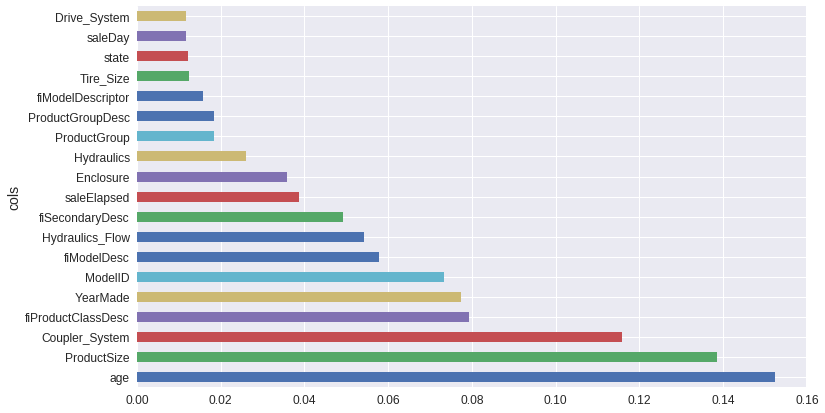

In [0]:
plot_fi(rf_feat_importance(m,X_train))

In [0]:
np.save('tmp/subs_cols.npy',np.array(df_subs.columns))

Let's go ahead and say alright, that was pretty darn good. Let's now leave it for a while so give it 160 trees. let it chew on it, and see how that goes.

# Our final model, 


In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5,n_jobs=-1, oob_score=True)
%time m.fit(X_train,y_train)
print_score(m)

CPU times: user 5min 22s, sys: 4.36 s, total: 5min 26s
Wall time: 2min 49s
[0.08016512405916282, 0.21159776425034824, 0.9865690799442552, 0.9200404901535328, 0.9145633398273597]


As you can see, we did all of our interpretation, all of our fine-tuning basically with smaller models/subsets and at the end, we run the whole thing. And it actually still only took 16 seconds and so we 've got now an RMSE of 0.21. Now we can check that against Kaggle. Unfortunately, this is an older competition and we are not allowed to enter anymore to see how we would have gone. So the best we can do is check whether it looks like we could have done well based on their validation set so it should be in the right area. Based on that, we would have come first. 

I think this is an interesting series of steps. So you can go through the same series of steps in your Kaggle projects and more importantly , you real-world projects. One of the challenges is once you leave this learning enviroment, suddenly you are surrounded by people who never have enough time, they always want to to be in hurry, they're always telling you do this and then do that. You need to find the time to step away and go back because this is an genuine real-world modeling process you can use. And it gives, when I said gives world-class results, I mean it. The guy who wont this, Leustagos, sadly he passed away but he is the top Kaggle competitor of all time. He won I believe dozens of competitions so if we can get a score even within his score, then we are doing very well. 

**Charification** [1:01:31](https://youtu.be/3jl2h9hSRvc?t=1h1m31s): The change in $R^2$ between these two is not just due to the fact removed these three predictors. We also went reset_rf_samples(). So to actually see the impact of just removing , we need to compare it to the final step earlier. 

![alt text](https://cdn-images-1.medium.com/max/800/1*5VqfngZfHNjcD7fLmvX8hQ.png)

So it's actually compared to 0.907 validation. So removing those three things took us from 0.907 to 0.915. In the end, of course, what matters is our final model but just to clarify.

# Writing Random Forest from Scratch! [1:02:31](https://youtu.be/3jl2h9hSRvc?t=1h2m31s)

Implementing random forest algorithm is actually quite tricky not because the code is tricky 1:05:03. Generally speaking, most random forest algorithms are pretty conceptually easy. Academic papers and books have a knack of making them look difficult, but they are not actually difficult conceptually. What's difficult is getting all the details right and knowing when you re right. In other words, we need a good way of doing testing. So if we are going to reimplement something that already exists, like say we want to create a random forest in some different framework, different language, different operating system, I would always start with something that does exist. So in this case, we're just going to do it as learning excercise, writing a random forest in Python, so for testing, I 'm going to compare it to an existing random forest implementation.

That's critical. Anytime you are doing anything involving non-trivial amounts of code in machine learning, knowning whether you've got it right or wrong is the hardest hit. I always assume that I've screwed everything up at every step, and so I'm thinking okay assuming that I screwed it up , how do I figure out that I screwed it up. Then much to my surprise from time to time, I actually got something right and then I can move on. But most of the time, I get it wrong, so unfortunately with machine learning, there's a lot of ways you can get things wrong that don't give you an error. They just make your result slightly less good and so that's what you want to pick up.

My way of writting nearby all code is top-down just like my teaching. So by top-down, I start by assuming that everything I want already exists. In other words, the first thing I want to do, I'm going to call this a tree ensemble. To create a random forest, the first question I have is what I do need to pass in. What do I need to initialize my random forest. I'm going to need:
- **x** : some independent variables
- **y** : some dependent variable
- **n_trees** : pick how many trees I want
- **sample_sz**: I'm going to use the sample size parameter from the start here, so how big you want each sample to be.
- **min_leaf** : then maybe some optional parameter of what's the smallest leaf size.

In [0]:
class TreeEnsemble():
    def __init__(self,x,y,n_trees,sample_sz,min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs],self.y[rnd_idxs],
                           min_leaf = self.min_leaf)
    
    def predict(self,x):
        return np.mean([t.predict(x) for t in self.trees])

For testing, it's nice to use a constant random seed, so we'll get the same result each time. So **np. random.seed(42)** is how you set a random seed. Maybe it's worth mention for those of you who aren't familiar with it, random number generators on computers aren't random at all. They are actually called pseudo random number generators and what they do is given some initial starting point (in this case 42), a pseudo random number generator is a mathematical function that generates a deterministic (always the same) sequence of numbers such that those numbers are designed to be:
- as uncorrelated with the previous number as possible
- as unpredictable as possible
- as uncorrelated as possible with something with a different random seed ( so the second number in the sequence starting with 42 should be very different to the second number starting with 41)

And generally, they involve using big prime numbers, taking mods, and stuff like that. It 's an interesting area of math. If you want real random numbers, the only way to do that is you can actually buy hardware called a hardware random number generator that'll have inside them like a little bit of some radioactive substance and something that detects how many things it's splitting out or there'll be some hardware thing.

**Question**: Is current system time a valid random number generation [1:09:25](https://youtu.be/3jl2h9hSRvc?t=1h9m25s)? 
- So that would be maybe for a random seed (the thing we start the function with). One of the really interesting area is in your computer, if you don't set the random seed, what is it set to. Quite often, people use the current time for security - obviously we use a lot of random number stuff for security, like if you are generating an SSH key, it needs to be random. It turns out people can figure out roughly when you created a key. They could look at oh, **id_rsa** has a timestamp and they could try all the different nanoseconds starting points for a random number generator around the timestamp and figure out your key. So in practice, a lot of high randomness requiring applications actually have a step that say " please move your mouse and type random stuff at the keyboard for a while" and so it gets you to be a source of "entropy". Other approach is they'll look at the hash of some of your log files or stuff like that. It's really really fun area.

In our case, our purpose actually is to remove randomness [1:10:48](https://youtu.be/3jl2h9hSRvc?t=1h10m48s). So we are saying okay, generate a series of pseudo random numbers starting with 42, so it always should be the same.

If you haven't done much stuff in Python OO, this is basically standard idiom at least I write it this way, most people don't, but if you pass in 5 things that **you are going to want to keep inside this object, then you basically have to say self.x = x** , etc. We can assign a tuple from a tuple.

![alt text](https://cdn-images-1.medium.com/max/800/1*umGtgE21wqSPBD3oL-o_CQ.png)

This is my of coding. Most people thing this is horrible, but I prefer to be able to see everything at once and I know in my code anytime I see something that looks like this, it's always all of the stuff in the method being set. If I did it a different way, then half of the code now come off the bottom of the page and you can't see it. 

So that was the first thing I thought about -- to create a random forest what information do you need. Then I'm going to need to store that information inside my project, and then I need to create some trees. A random forest is something that has some trees. So I basically figured to use list comprehension to create a list of trees. How many trees do we have? We got **n_trees** trees. That's what we asked for. **range(n_trees)** gives me the number from 0 up to **n_trees-1**. So if I create a list comprehension that loops through that range calling **create_tree** each time, I now have **n_trees** trees.

To write that, I didn't have to think at all. That's all obvious. So I've delayed the thinking to the point where it's like well wait, we don't have something to create a tree. Okay, no worries. But let's pretend we did. If we did, we've now created a random forest. We'd still need to do a few things on the top of that. For example, once we have it we need a predict function. Okay, let's write a predict function. How do you predict in a random forest? For a particular row (or rows), go through each tree, calculate its prediction. So here is a list comprehension that is calculating the prediction for every tree for **x**. I don't know if **x** is one row or multiple rows, it doesn't matter as long as **tree.predict** works on it. And once you've got a list of things , a cool thing to know is you can pass **numpy.mean** a regular non numpy list and it will take the mean -- you just need to tell it axis = 0 means average across the lists. So this is going to return the average of **.predict()** for each tree.

I find list comprehensions allow me to write the code in the way the brain works [1:14:24](https://youtu.be/3jl2h9hSRvc?t=1h14m24s). You could the words and translate them into this code, or you could take this code and translate them into words. So when I write code, I want it to be as much like that as possible. I want it to be readable and so hopefully you'll find when you look at the fast.ai code trying to understand how Jeremy did **x**, I try to write things in a way that you can read it and turn it into English in your head. 

We've nearly finished writing our random forest, haven't we [1:15:29](https://youtu.be/3jl2h9hSRvc?t=1h15m29s)? All we need to do now is write create_tree. We will construct a decision tree (i.e non-random tree) from a random sample of the data. So again, We've delayed any actual thought process here. We've basically said ok, we could pick some random IDs, This is good trick to know. If you call **np.random.permutation** passing in an **int**, it'll **give you back a randomly shuffled sequence** from 0 to that **int**. So if you grab the first **: n** items of that, that's now a random subsample. So this is not doing boostrapping (i.e we are not doing sampling with replacement) here which I think is fine. For my random forest, I 'm deciding that it's going to be something where we do subsampling not boostrapping. 

![alt text](https://cdn-images-1.medium.com/max/800/1*IsOzXklCDEfpArLTaMduVA.png)



```
np.random.permutation(len(self.y))[:self.sample_sz]
```

So here is a good line of code to know how to write because I feel like most of the time, we have more data than we want to put in a tree at once [1:18:54](https://youtu.be/3jl2h9hSRvc?t=1h18m54s). Back when Breiman created random forest, it was 1999 and was a very different world. We now have too much data. So what people tend to do is fire-up a spark cluster and they will run it on hundreds of machines when it makes no sense because if they had just used a subsample each time, they could have done it on one machine. The overhead of spark is a huge amount of I/O overhead. If you do something on a single machine, it can often be hundreds of times faster because you don't have this I/O overhead and it also tends to be easier to write the algorithms, easier to visualize, cheaper and so forth. So I almost always avoid distributed computing and I have my whole life. Even 25 years ago when I was starting in machine learning, I still didn't use clusters because I always feel like whatever I could do with a cluster now, I could do with a single machine in 5 years time. So why not focus on always being as good as possible with a single machine. That would be more interactive and iterative.

So again, we delayed thinking to the point where we have to write decision tree [1:20:26](https://youtu.be/3jl2h9hSRvc?t=1h20m26s). So hopefully you get an idea that this top-down approach, the goal is going to be that we're going to keep delaying thinking so long that eventually we've somehow wrttten the whole thing without actually having to think. Notice that you never have to design anything. You just say, what if somebody already gave me the exact API I would need to implement that? you keep going down until eventually you notice oh, that aldready exists. 

This assumes we've got a class called **DecisionTree**, so we're going to have to create that [1:21:13](https://youtu.be/3jl2h9hSRvc?t=1h21m13s). We know what we're going to have to pass it because we just passed it. So we are passing in random sample of x's and y's. We know that a decision tree is going to contain decision tree, there's going to be some subset of the original data that we've kind of got so I'm going to pass in the indexes of the data what we're actually going to use here. So initially, it's the entire random sample. And we also pass down the min_leaf size. So everything that we got for constructing the random forest, we'll pass down to decision tree except, of course, **num_tree** which i

In [0]:
class DecisionTree():
    def __init__(self,x,y,idxs=None,min_leaf=5):
        if idxs is None: idxs = np.arange(len(y))
        self.x, self,y, self.idxs, self.min_leaf = x,y,idxs,min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
    
    # This just does one decision; we'll make it recursive later    
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
    # We will write this later 
    def find_better_split(self,var_idx): pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): 
        return self.x.values[self.idxs, self.var_idx]
    
    @property
    def is_leaf(self):
        s = f'n:{self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score};split:{self.split};var:{self.split_name}'
            return s

- **self.n** : how many rows we have in this tree ( the number of indexes we've given)
- **self.c** : how many columns we have (how ever many columns there are in the independent variables)
- **self.val** : for this tree, what's its prediction. Prediction of this is the mean of our dependent variable for those indexes. When we talk about indexes, we are not talking about the random sampling to create the tree. We're assuming this tree now has some random sample. Inside decision tree, the whole random sampling thing is gone. That was done by the random forest. So at this point, we are building something that is just a plain old decision tree. It's not in anyway a random sampling anything. So indexes is literally which subset of the data have we got to so far in this tree. 